# Linear Regression
Now, we have chosen transformations for the features and created subsamples for our variables of interest. Next, we want to see if they still give predictive power and how much using a linear regression model.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import statsmodels.api as sma
import statsmodels as sms
from statsmodels.stats import outliers_influence

import warnings
warnings.filterwarnings(action="ignore")

/home/phil/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
data_path = "/media/veracrypt1/SPON_dataset_tables/"
plot_path = "plots/"

In [3]:
def prepare_type(df_data):
    # Nominal features
    df_data["sex"] = df_data["sex"].astype("category")
    df_data["familyStatus"] = df_data["familyStatus"].astype("category")
    df_data["employment"] = df_data["employment"].astype("category")
    df_data["housing"] = df_data["housing"].astype("category")
    df_data["east_west"] = df_data["east_west"].astype("category")

    # Ordinal features
    cat_ordtype = pd.api.types.CategoricalDtype(categories=[500, 1000, 2000, 3000, 4000, 5000], ordered=True)

    df_data["monthlyIncome"] = df_data["monthlyIncome"].astype(cat_ordtype)
    df_data["activeLoanAmount"] = df_data["activeLoanAmount"].astype(cat_ordtype)
    df_data["paidOffLoanAmount"] = df_data["paidOffLoanAmount"].astype(cat_ordtype)
    
    return df_data

In [4]:
def do_scatter(fitted, res, y_lab, fit_lowess=False):
    if fit_lowess:
        seaborn.regplot(fitted, res, lowess=True)
    else:
        plt.scatter(fitted, res)
    plt.xlabel(y_lab)
    plt.ylabel("residuals")
    plt.show()
    plt.close()
    

def do_hist(res):
    plt.hist(res)
    plt.xlabel("residuals")
    plt.ylabel("frequency")
    plt.show()
    plt.close()

In [5]:
def get_feature_lists(domain):
    # Separate Columns into data types as well as predictors and target

    nominal = ["sex", "east_west", "mailOrder"]
    nom_idx = len(nominal)

    metric = ['monthlyIncome', 'age', 'relocation', # questionnaire data
              'request', 'banking_connection', 'business_relation', 'conditions',
              'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
              'solvency', 'telecom', 'unsecured_loan', # feature counts
              domain+'_req', 'finance_year', # request/time counts
              'credit_days', 'credit_card_days', 'giro_days'] # time-based

    target = ["score"]



    # Separate Columns into counts (discrete with zero-inflation) and non-counts

    counts = ['relocation', 
              'request', 'banking_connection', 'business_relation', 'conditions',
              'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
              'solvency', 'telecom', 'unsecured_loan',
              domain+'_req', 'finance_year']

    non_counts = ["female", "east", "mailOrder",
                  'monthlyIncome', 'age', 
                  'credit_days', 'credit_card_days', 'giro_days']
    
    return nominal, nom_idx, metric, target, counts, non_counts

In [6]:
# dataset and list of Features that we selected in the ranking
def create_dataset(ds, relevant_feats, nominal, metric, target, feat_list, standardized=True):
    
    ds.iloc[:, -26:] = ds.iloc[:, -26:].fillna(0)

    Xy = ds[relevant_feats + ["weight"]]
    print(Xy.shape)
    Xy = Xy.dropna()
    print(Xy.shape)
    
    #metric.remove("monthlyIncome")
    #nominal += ["monthlyIncome"]
    
    df_metric = Xy[metric] # [:, (nom_idx+1):]
    df_nominal = Xy[nominal] # [:, 1:(nom_idx+1)]
    y = Xy[target] # [:, 0]
    
    ###############
    
    # Transform features
    # Nominal
    # Code nominal feature
    df_female = pd.get_dummies(df_nominal.sex.astype("category"))["female"].reset_index(drop=True).to_frame()
    df_east = pd.get_dummies(df_nominal.east_west.astype("category"))["east"].reset_index(drop=True).to_frame()
    df_mail = df_nominal.mailOrder.astype(int).reset_index(drop=True).to_frame()

    # Ordinal
    #df_monthlyIncome = df_nominal.monthlyIncome.reset_index(drop=True).cat.codes.to_frame()
    #df_monthlyIncome.columns = ["monthlyIncome"]
    df_metric.monthlyIncome = df_metric.monthlyIncome.cat.codes

    df_nominal = pd.concat([df_female, df_east, df_mail], axis=1)

    # Metric
    # Expand metric features
    poly_2 = df_metric.apply(lambda x: x**2)
    poly_2.columns = poly_2.columns + "_**2"

    poly_3 = df_metric.apply(lambda x: x**3)
    poly_3.columns = poly_3.columns + "_**3"

    log_2 = df_metric.apply(lambda x: np.log(x+1))
    log_2.columns = log_2.columns + "_log2"

    # Compute interaction terms
    interactions = pd.DataFrame(index = df_metric.index)

    for idx, feat in enumerate(df_metric.columns):
        for interact in df_metric.columns[idx+1:]:
            interactions[feat+"*"+interact] = df_metric[feat]*df_metric[interact]
            
    # append features
    metric_Xy = pd.concat([y, df_metric, poly_2, poly_3, log_2, interactions], axis=1)
    
    ################
    
    # scale metric features
    scaler = StandardScaler()
    metric_Xy_scaled = pd.DataFrame(scaler.fit_transform(metric_Xy), columns=metric_Xy.columns)

    # concatenate all features and separate y
    if standardized:
        y = metric_Xy_scaled["score"]
        X = pd.concat([df_nominal, 
                       metric_Xy_scaled, 
                       Xy["weight"].to_frame().reset_index(drop=True)], axis=1)
    else:
        y = y.reset_index(drop=True)
        X = pd.concat([df_nominal, 
                       metric_Xy.reset_index(drop=True), 
                       Xy["weight"].to_frame().reset_index(drop=True)], axis=1)

    X = X[feat_list+["weight"]]

    return X, y

In [7]:
def evaluate_vifs(X, thresh=10):
    
    # Add intercept term
    X = sma.add_constant(X)
    
    # compute vifs
    vifs = [outliers_influence.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    for i, col in enumerate(X.columns):
        if vifs[i] >= thresh:
            print("%s has to high vif=%f"%(col, vifs[i]))

In [8]:
def do_regression(X, y):
    
    weights = X.weight.values
    
    X.drop("weight", axis=1, inplace=True)

    # Evaluate VIF except from column "weight"
    evaluate_vifs(X)
        
    # Prune features with just one characteristic
    no_info = []
    for i in X.columns:
        if len(X[i].unique()) == 1:
            print("Has only one characteristic: %s"%(i))
            no_info.append(i)
    
    X.drop(no_info, axis=1, inplace=True)

    # Add intercept term (and ignore weight-column)
    X = sma.add_constant(X)
    print(X.shape, y.shape)

    # Apply regression
    reg = sma.WLS(y, X, weights=weights).fit()

    # Check Assumptions
    # random, normal
    do_scatter(y, reg.resid, y_lab="y_scaled")
    do_scatter(reg.fittedvalues, reg.resid, y_lab="fitted_values", fit_lowess=True)
    print("Mean of residuals", np.mean(reg.resid))
    print("RMSE: %f"%(np.sqrt(((reg.resid)**2).mean())))
    do_hist(reg.resid)
    print("----")
    # Homoscedasticity
    print("Het-Breuschpagan for homogenity:\n", sms.stats.diagnostic.het_breuschpagan(reg.resid, X))
    print("Het white for homogenity:\n", sms.stats.diagnostic.het_white(reg.resid, X))

    return reg

In [9]:
def persist_model_quality(linreg, filename):
    model_quality = {"rsq": [linreg.rsquared],
                     "rsq_adj": [linreg.rsquared_adj],
                     "aic": [linreg.aic],
                     "ll": [linreg.llf],
                     "f_stat": [linreg.fvalue],
                     "f_p": [linreg.f_pvalue],
                     "rmse": [np.sqrt(((linreg.resid)**2).mean())]}

    pd.DataFrame.from_dict(model_quality).to_csv(filename, index=False, sep=";")

In [10]:
def persist_model_coeffs(linreg, predictors, filename):
    ci = linreg.conf_int()
    model_coeffs = {"predictor": predictors,
                    "coefficient": linreg.params.values,
                    "pvalue": linreg.pvalues.values,
                    "standard error": linreg.bse.values,
                    "0.025": ci.values[:, 0],
                    "0.975": ci.values[:, 1]}
    
    pd.DataFrame.from_dict(model_coeffs).to_csv(filename, index=False, sep=";")

In [11]:
# functions for regression
def convert_to_unstandardized(sd_y, sd_x, beta):
    return beta * (sd_y/sd_x)

def get_semi_partial_corr(y, a, X):
    reg = sma.OLS(a, sma.add_constant(X))
    residuals = reg.fit().resid
    return stats.pearsonr(residuals, y)[0]

def multicol_index(spc, a, X):
    reg = sma.OLS(a, sma.add_constant(X))
    a_hat = reg.fit().fittedvalues
    r2_a, _, _ = compute_r2(a_hat.values, a.values)
    return 1 / np.sqrt(1-r2_a)

## Age

In [12]:
table2 = pd.read_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_age.csv", sep=";")

In [13]:
table2 = prepare_type(table2)

### Banken - Version 1

In [14]:
domain = "Banken"

In [15]:
variable = "age"

#### Transformations & Standardization

In [16]:
# As an example we use banken V1
version = 1

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

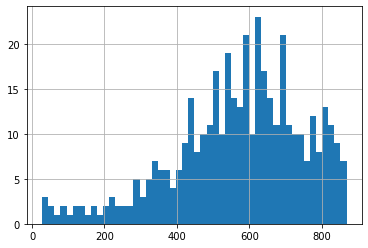

In [17]:
df_data["score"].hist(bins=50)
plt.show()
plt.close()

"""df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(1000-x)*100)
df_data["score"].hist(bins=50)
plt.show()
plt.close()""";

In [18]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [19]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [20]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [21]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(410, 25)
(410, 25)


(410, 2) (410,)


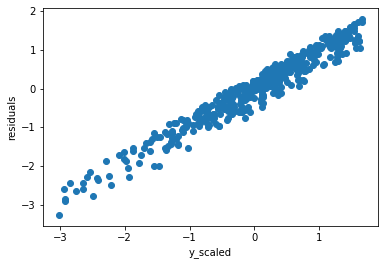

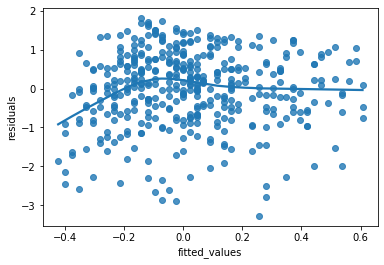

Mean of residuals -0.020052565028166384
RMSE: 0.965793


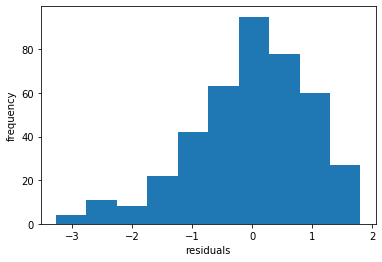

----
Het-Breuschpagan for homogenity:
 (2.0556077316980623, 0.15164673724646724, 2.0558879357782915, 0.1523847623513144)
Het white for homogenity:
 (3.0459821791189476, 0.21805867750160426, 1.5231631739867248, 0.21926129128826524)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.054
Model:                            WLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     23.24
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           2.02e-06
Time:                        13:46:45   Log-Likelihood:                -568.46
No. Observations:                 410   AIC:                             1141.
Df Residuals:                     408   BIC:                             1149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201      0.047      0.423      0.672      -0.073       0.113
age            0.2266      0.047      4.821      0.000       0.134       0.319
==============================================================================
Omnibus:                       28.944   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.520
Skew:                          -0.637   Prob(JB):                     5.26e-08
Kurtosis:                       3.582   Cond. No.                         1.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [23]:
print("Unit influence of variable: %f"%convert_to_unstandardized(df_data.score.std(), df_data.age.std(), linreg.params[1]))

Unit influence of variable: 4.194211


const has to high vif=17.090476
(410, 2) (410,)


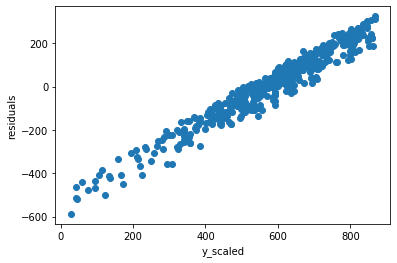

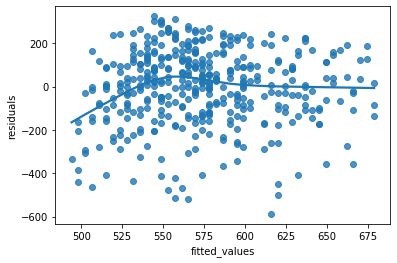

Mean of residuals -3.600250042439781
RMSE: 173.399087


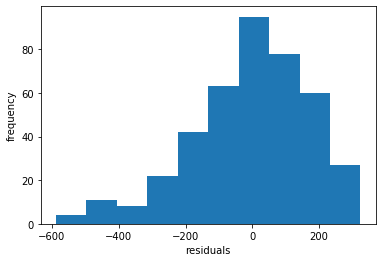

----
Het-Breuschpagan for homogenity:
 (2.055607731698108, 0.15164673724646285, 2.0558879357783515, 0.15238476235130965)
Het white for homogenity:
 (3.0459821791189476, 0.21805867750160426, 1.5231631739867406, 0.2192612912882532)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.054
Model:                            WLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     23.24
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           2.02e-06
Time:                        13:46:49   Log-Likelihood:                -2696.5
No. Observations:                 410   AIC:                             5397.
Df Residuals:                     408   BIC:                             5405.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        410.2904     36.151     11.349      0.000     339.224     481.357
age            4.1942      0.870      4.821      0.000       2.484       5.904
==============================================================================
Omnibus:                       28.944   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.520
Skew:                          -0.637   Prob(JB):                     5.26e-08
Kurtosis:                       3.582   Cond. No.                         179.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
do_regression(df_data[["age", "weight"]].copy(), df_data["score"]).summary()

In [25]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [26]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

const has to high vif=10.358611


const has to high vif=10.358611
(410, 21) (410,)


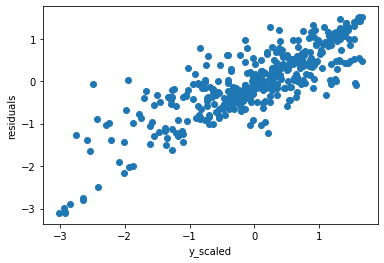

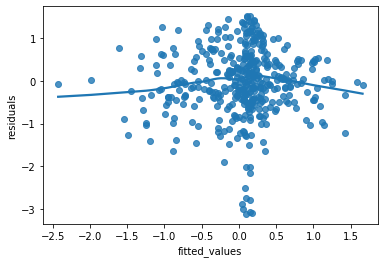

Mean of residuals -0.03274357307287291
RMSE: 0.809983


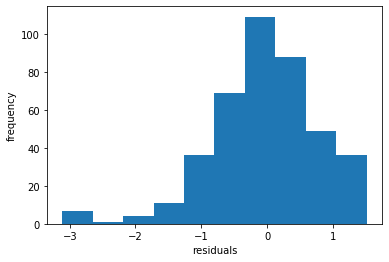

----
Het-Breuschpagan for homogenity:
 (33.68730533347532, 0.02831941012688689, 1.74115329624138, 0.02536280082734515)
Het white for homogenity:
 (103.99759321983147, 0.9999999999996215, 0.28068690800203766, 0.9999999999999999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.334
Model:                            WLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     9.773
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           3.24e-24
Time:                        13:46:51   Log-Likelihood:                -496.36
No. Observations:                 410   AIC:                             1035.
Df Residuals:                     389   BIC:                             1119.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0380      0.127     -0.299      0.765      -0.288       0.212
credit_card_days           0.3599      0.051      7.071      0.000       0.260       0.460
relocation                -0.0746      0.042     -1.762      0.079      -0.158       0.009
solvency_log2             -0.3728      0.048     -7.797      0.000      -0.467      -0.279
female                     0.1488      0.145      1.028      0.305      -0.136       0.433
finance_year_**2          -0.0080      0.054     -0.149      0.881      -0.114       0.098
mailOrder                  0.0636      0.128      0.495      0.621      -0.189       0.316
secured_loan_**2           0.0391      0.044      0.895      0.371      -0.047       0.125
giro_days                  0.1715      0.059      2.888      0.004       0.055       0.288
credit_card_**2           -0.0432      0.048     -0.907      0.365      -0.137       0.050
conditions_**2            -0.0793      0.045     -1.774      0.077      -0.167       0.009
giro                      -0.1275      0.065     -1.956      0.051      -0.256       0.001
unsecured_loan_**3        -0.0420      0.041     -1.023      0.307      -0.123       0.039
identity_**2              -0.0292      0.042     -0.693      0.488      -0.112       0.054
credit_days_log2          -0.0661      0.050     -1.321      0.187      -0.165       0.032
telecom_log2              -0.1150      0.044     -2.586      0.010      -0.202      -0.028
global_credit_**2          0.0538      0.051      1.044      0.297      -0.047       0.155
banking_connection_**2    -0.0161      0.043     -0.378      0.705      -0.100       0.067
east                       0.0055      0.104      0.053      0.958      -0.198       0.209
business_relation_**2     -0.0656      0.042     -1.558      0.120      -0.148       0.017
monthlyIncome              0.0636      0.044      1.448      0.148      -0.023       0.150
==============================================================================
Omnibus:                       43.526   Durbin-Watson:                   2.232
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.301
Skew:                          -0.649   Prob(JB):                     2.70e-17
Kurtosis:                       4.667   Cond. No.                         8.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [28]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [29]:
evaluate_vifs(X_scaled.iloc[:,:-1])

const has to high vif=10.358638


const has to high vif=10.358638
(410, 22) (410,)


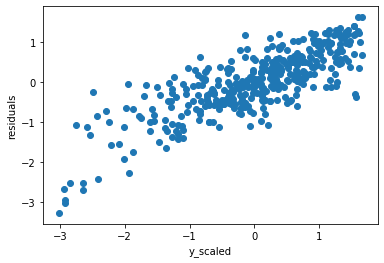

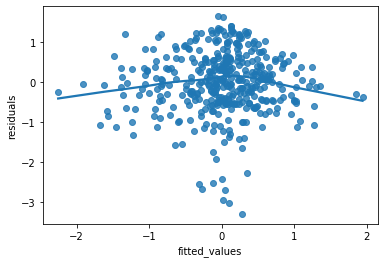

Mean of residuals -0.0063039236625582395
RMSE: 0.784925


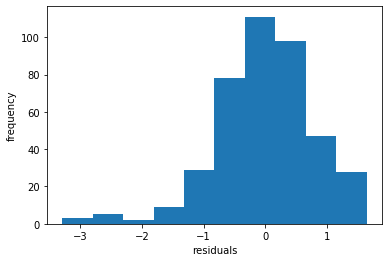

----
Het-Breuschpagan for homogenity:
 (32.70175980819527, 0.04963054440523222, 1.6013961337738825, 0.04587011502719393)
Het white for homogenity:
 (110.33742066895768, 0.9999999999999959, 0.2464722772200073, 0.9999999999999999)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.371
Model:                            WLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     10.87
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           5.42e-28
Time:                        13:47:02   Log-Likelihood:                -484.94
No. Observations:                 410   AIC:                             1014.
Df Residuals:                     388   BIC:                             1102.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0575      0.124     -0.465      0.642      -0.301       0.186
age                        0.1919      0.041      4.716      0.000       0.112       0.272
credit_card_days           0.3670      0.050      7.401      0.000       0.270       0.464
relocation                -0.0382      0.042     -0.910      0.363      -0.121       0.044
solvency_log2             -0.3766      0.047     -8.087      0.000      -0.468      -0.285
female                     0.0845      0.142      0.597      0.551      -0.194       0.363
finance_year_**2          -0.0013      0.053     -0.025      0.980      -0.105       0.102
mailOrder                  0.0619      0.125      0.495      0.621      -0.184       0.308
secured_loan_**2           0.0422      0.043      0.991      0.322      -0.042       0.126
giro_days                  0.1447      0.058      2.491      0.013       0.031       0.259
credit_card_**2           -0.0519      0.046     -1.119      0.264      -0.143       0.039
conditions_**2            -0.0781      0.044     -1.795      0.073      -0.164       0.007
giro                      -0.0999      0.064     -1.568      0.118      -0.225       0.025
unsecured_loan_**3        -0.0530      0.040     -1.324      0.186      -0.132       0.026
identity_**2              -0.0270      0.041     -0.659      0.511      -0.108       0.054
credit_days_log2          -0.0624      0.049     -1.281      0.201      -0.158       0.033
telecom_log2              -0.1050      0.043     -2.422      0.016      -0.190      -0.020
global_credit_**2          0.0486      0.050      0.969      0.333      -0.050       0.147
banking_connection_**2    -0.0120      0.041     -0.291      0.771      -0.093       0.069
east                       0.0069      0.101      0.069      0.945      -0.191       0.205
business_relation_**2     -0.0654      0.041     -1.596      0.111      -0.146       0.015
monthlyIncome              0.0507      0.043      1.184      0.237      -0.034       0.135
==============================================================================
Omnibus:                       51.345   Durbin-Watson:                   2.190
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               95.538
Skew:                          -0.727   Prob(JB):                     1.80e-21
Kurtosis:                       4.866   Cond. No.                         8.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [31]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.std(), linreg.params[1]))

spc = get_semi_partial_corr(y_scaled, X_scaled[variable], X_scaled.drop([variable, "weight"], axis=1))
print("Semi-Partial Coefficient: %f\nDifference to regression coefficient: %f"%(spc, spc - linreg.params[1]))

Unit influence of variable: 3.552058

Semi-Partial Coefficient: 0.193752
Difference to regression coefficient: 0.001857


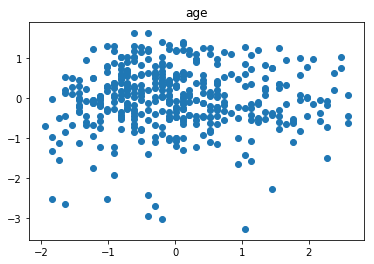

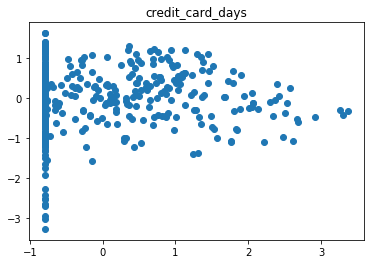

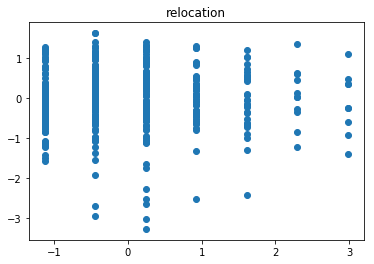

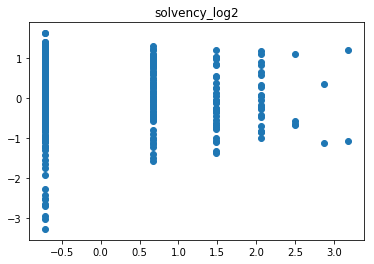

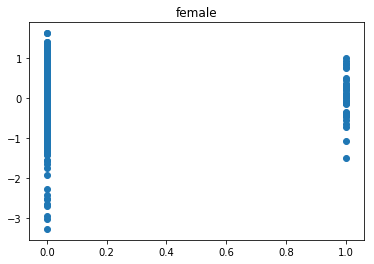

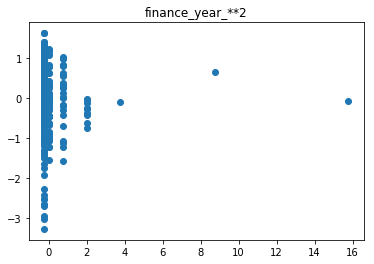

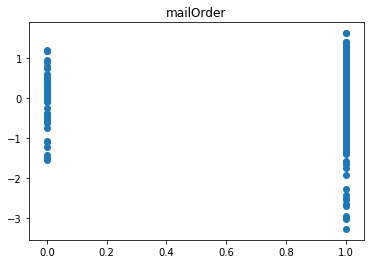

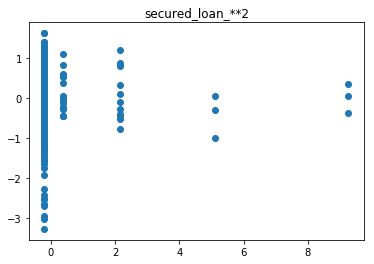

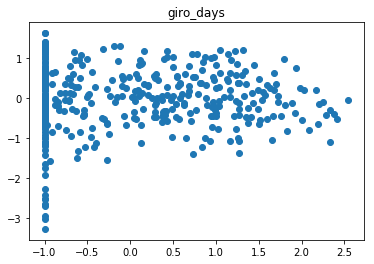

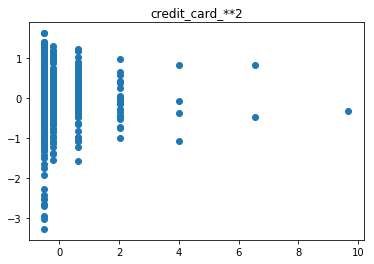

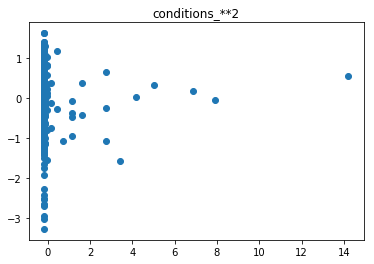

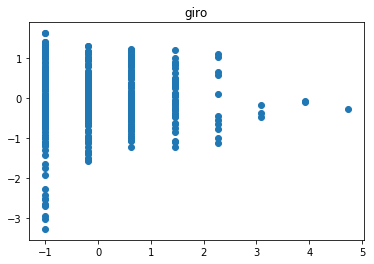

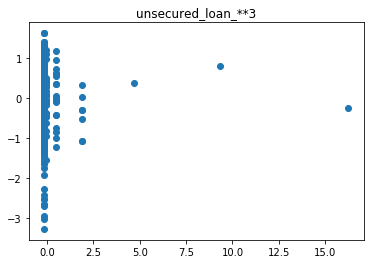

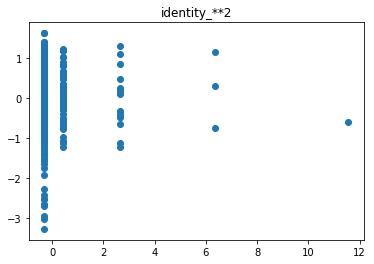

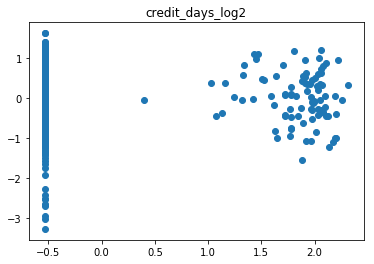

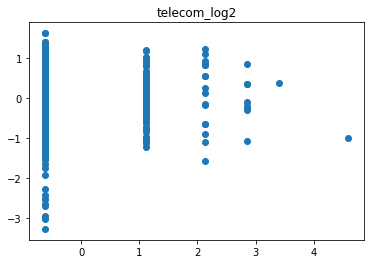

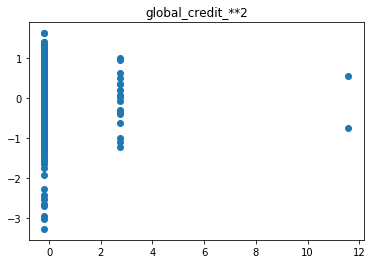

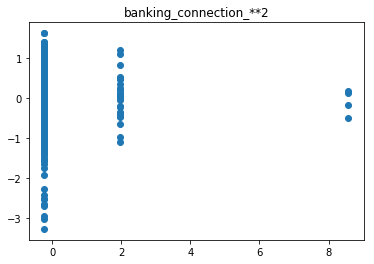

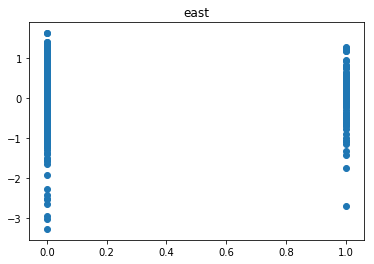

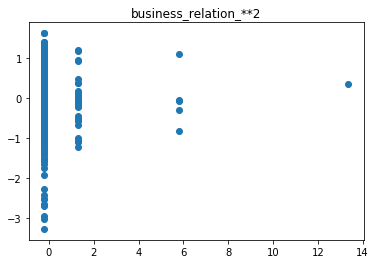

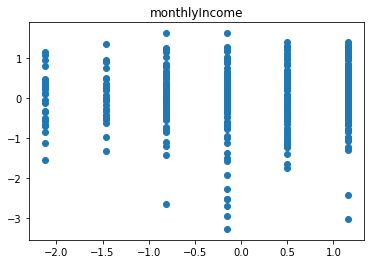

In [28]:
# EXAMINE RESIDUALS vs EACH VARIABLE
for f in feat_l:
    plt.scatter(X_scaled[f], linreg.resid)
    plt.title(f)
    plt.show()
    plt.close()

In [29]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Banken, Version 2

In [21]:
variable = "age_log2"

In [22]:
# As an example we use banken V1
version = 2

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

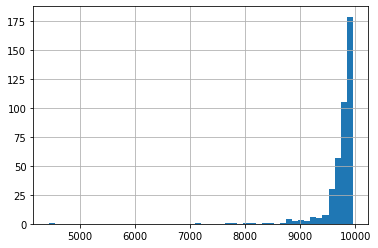

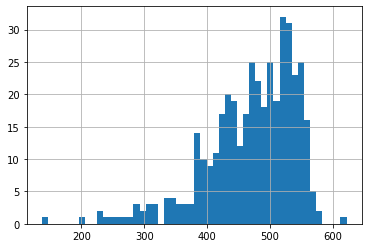

In [20]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)
df_data["score"].hist(bins=50)
plt.show()

In [35]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [36]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [37]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [38]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(410, 25)
(410, 25)


(410, 2) (410,)


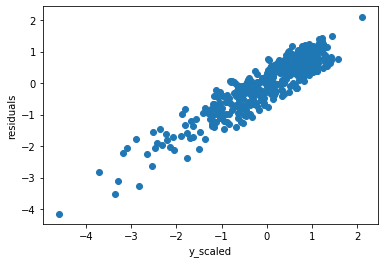

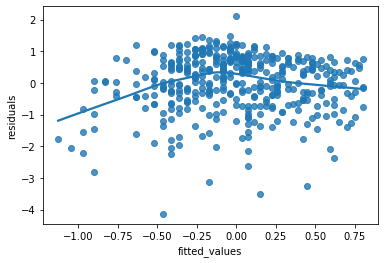

Mean of residuals 0.004298787867277244
RMSE: 0.905614


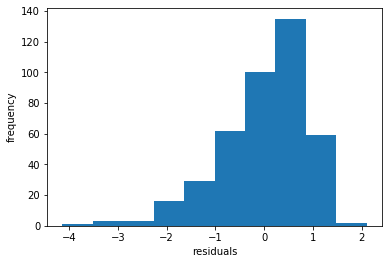

----
Het-Breuschpagan for homogenity:
 (5.470844988620663, 0.019336274446092337, 5.517784633580824, 0.01930028074325138)
Het white for homogenity:
 (7.6935199387089455, 0.021348795252489505, 3.8916383034365833, 0.021175825084623925)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.154
Model:                            WLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     74.41
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           1.42e-16
Time:                        13:47:45   Log-Likelihood:                -548.29
No. Observations:                 410   AIC:                             1101.
Df Residuals:                     408   BIC:                             1109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.045     -0.095      0.924      -0.093       0.084
age_log2       0.3917      0.045      8.626      0.000       0.302       0.481
==============================================================================
Omnibus:                       69.308   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.933
Skew:                          -1.024   Prob(JB):                     4.94e-25
Kurtosis:                       4.535   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [41]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.apply(np.log).std(), linreg.params[1]))

Unit influence of variable: 110.060952



In [42]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [43]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(410, 21) (410,)


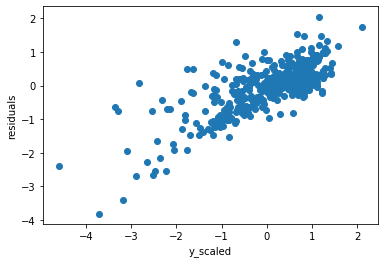

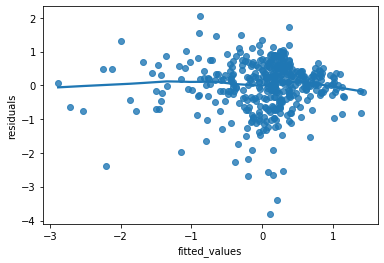

Mean of residuals -0.03353192380018271
RMSE: 0.757438


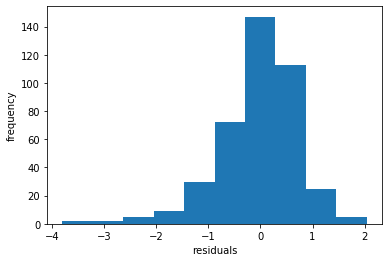

----
Het-Breuschpagan for homogenity:
 (36.32325537214825, 0.014088619645871171, 1.8906376357241088, 0.011994232767531554)
Het white for homogenity:
 (124.10099484307989, 0.9999999860216214, 0.3656379378646628, 0.9999999999994501)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.444
Model:                            WLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     15.54
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           2.50e-38
Time:                        13:55:29   Log-Likelihood:                -462.27
No. Observations:                 410   AIC:                             966.5
Df Residuals:                     389   BIC:                             1051.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0531      0.104     -0.509      0.611      -0.258       0.152
credit_card_days_log2      0.2885      0.065      4.407      0.000       0.160       0.417
giro_days                  0.3005      0.056      5.388      0.000       0.191       0.410
giro                      -0.2734      0.060     -4.573      0.000      -0.391      -0.156
solvency                  -0.2712      0.044     -6.156      0.000      -0.358      -0.185
unsecured_loan_log2       -0.1135      0.045     -2.510      0.012      -0.202      -0.025
female                    -0.0100      0.134     -0.074      0.941      -0.273       0.254
telecom                   -0.0685      0.040     -1.710      0.088      -0.147       0.010
relocation                -0.1521      0.040     -3.846      0.000      -0.230      -0.074
conditions_log2           -0.2155      0.047     -4.578      0.000      -0.308      -0.123
credit_card               -0.0665      0.062     -1.069      0.286      -0.189       0.056
finance_year_log2         -0.0044      0.051     -0.087      0.931      -0.104       0.095
secured_loan_log2          0.0824      0.041      2.003      0.046       0.002       0.163
business_relation         -0.1147      0.041     -2.817      0.005      -0.195      -0.035
identity_**3              -0.0264      0.043     -0.618      0.537      -0.110       0.057
east                       0.0177      0.093      0.190      0.850      -0.166       0.201
global_credit             -0.0512      0.039     -1.310      0.191      -0.128       0.026
banking_connection_**3     0.0549      0.036      1.543      0.124      -0.015       0.125
credit_days_**3           -0.0337      0.042     -0.793      0.428      -0.117       0.050
monthlyIncome              0.0604      0.040      1.496      0.135      -0.019       0.140
mailOrder                  0.0981      0.108      0.906      0.365      -0.115       0.311
==============================================================================
Omnibus:                       76.960   Durbin-Watson:                   2.118
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.153
Skew:                          -0.953   Prob(JB):                     2.06e-39
Kurtosis:                       5.606   Cond. No.                         8.31
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [45]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [46]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(410, 22) (410,)


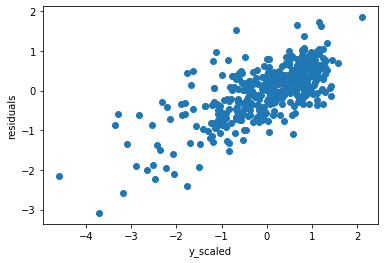

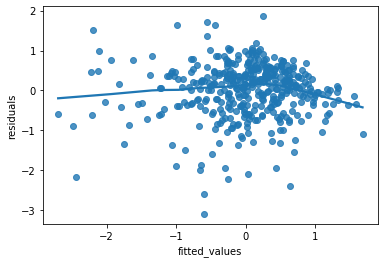

Mean of residuals 0.0018957138493745675
RMSE: 0.689369


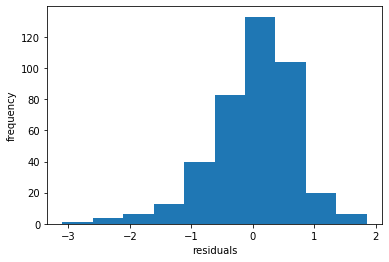

----
Het-Breuschpagan for homogenity:
 (44.03628119433037, 0.0023130167324707644, 2.2232332807875275, 0.00165530801208896)
Het white for homogenity:
 (222.0797391691826, 0.8162203301375075, 0.8155234195963597, 0.9261985901135046)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.529
Model:                            WLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     20.74
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           5.83e-51
Time:                        13:55:34   Log-Likelihood:                -428.33
No. Observations:                 410   AIC:                             900.7
Df Residuals:                     388   BIC:                             989.0
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0241      0.096     -0.250      0.803      -0.214       0.165
age_log2                   0.3059      0.037      8.358      0.000       0.234       0.378
credit_card_days_log2      0.3167      0.060      5.240      0.000       0.198       0.435
giro_days                  0.2605      0.052      5.045      0.000       0.159       0.362
giro                      -0.2477      0.055     -4.487      0.000      -0.356      -0.139
solvency                  -0.2498      0.041     -6.139      0.000      -0.330      -0.170
unsecured_loan_log2       -0.1071      0.042     -2.569      0.011      -0.189      -0.025
female                    -0.0294      0.124     -0.238      0.812      -0.272       0.213
telecom                   -0.0668      0.037     -1.810      0.071      -0.139       0.006
relocation                -0.0968      0.037     -2.614      0.009      -0.170      -0.024
conditions_log2           -0.1960      0.043     -4.512      0.000      -0.281      -0.111
credit_card               -0.1118      0.058     -1.942      0.053      -0.225       0.001
finance_year_log2         -0.0036      0.047     -0.077      0.938      -0.095       0.088
secured_loan_log2          0.0845      0.038      2.228      0.026       0.010       0.159
business_relation         -0.1198      0.038     -3.192      0.002      -0.194      -0.046
identity_**3              -0.0492      0.039     -1.250      0.212      -0.127       0.028
east                      -0.0091      0.086     -0.106      0.916      -0.178       0.160
global_credit             -0.0371      0.036     -1.027      0.305      -0.108       0.034
banking_connection_**3     0.0580      0.033      1.769      0.078      -0.006       0.122
credit_days_**3           -0.0653      0.039     -1.660      0.098      -0.143       0.012
monthlyIncome              0.0309      0.037      0.827      0.409      -0.043       0.104
mailOrder                  0.0314      0.100      0.314      0.754      -0.165       0.228
==============================================================================
Omnibus:                       58.726   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              102.983
Skew:                          -0.843   Prob(JB):                     4.34e-23
Kurtosis:                       4.786   Cond. No.                         8.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [48]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.apply(np.log).std(), linreg.params[1]))

spc = get_semi_partial_corr(y_scaled, X_scaled[variable], X_scaled.drop([variable, "weight"], axis=1))
print("Semi-Partial Coefficient: %f\nDifference to regression coefficient: %f"%(spc, spc - linreg.params[1]))

Unit influence of variable: 85.958029

Semi-Partial Coefficient: 0.308425
Difference to regression coefficient: 0.002519


In [49]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Banken, Version 3

In [50]:
variable = "age_log2"

In [51]:
version = 3

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

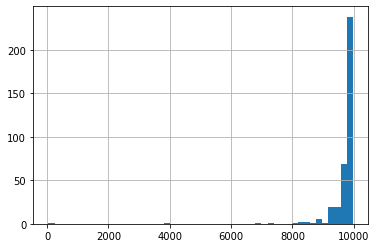

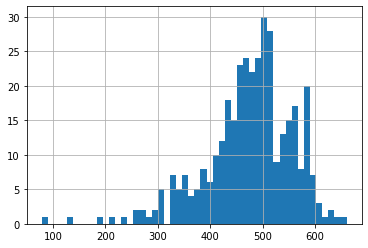

In [52]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)

df_data["score"].hist(bins=50)
plt.show()

In [53]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [54]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [55]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [56]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(362, 25)
(362, 25)


(362, 2) (362,)


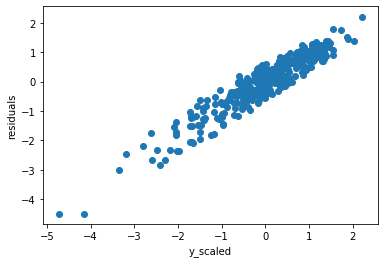

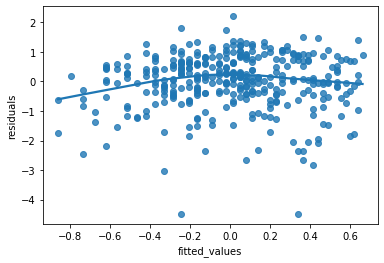

Mean of residuals -0.0017778222905444154
RMSE: 0.935367


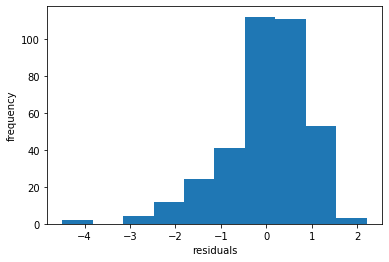

----
Het-Breuschpagan for homogenity:
 (0.6839118722501822, 0.4082429309140785, 0.6814207340886749, 0.40964460734063)
Het white for homogenity:
 (1.5988805749377066, 0.44958052956464445, 0.7963323300969668, 0.451774952418615)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.108
Model:                            WLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     43.48
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           1.53e-10
Time:                        13:56:20   Log-Likelihood:                -499.84
No. Observations:                 362   AIC:                             1004.
Df Residuals:                     360   BIC:                             1011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.050      0.035      0.972      -0.097       0.100
age_log2       0.3315      0.050      6.594      0.000       0.233       0.430
==============================================================================
Omnibus:                       86.481   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.734
Skew:                          -1.197   Prob(JB):                     3.14e-43
Kurtosis:                       5.691   Cond. No.                         1.16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [59]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.apply(np.log).std(), linreg.params[1]))

Unit influence of variable: 106.240246



In [60]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [61]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(362, 21) (362,)


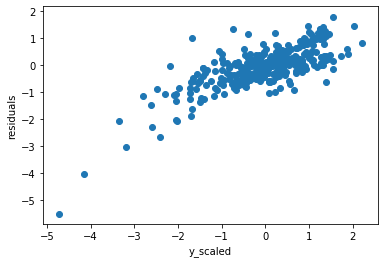

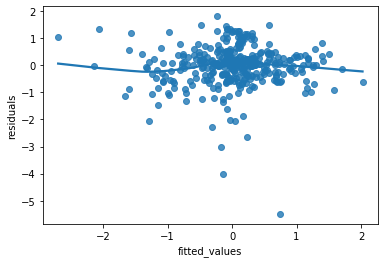

Mean of residuals -0.017643920330717888
RMSE: 0.754688


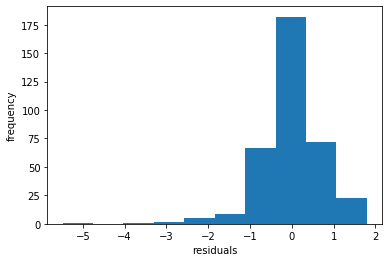

----
Het-Breuschpagan for homogenity:
 (13.462609910230247, 0.8566654025549348, 0.6585735289700357, 0.8658762311911061)
Het white for homogenity:
 (241.34439553546798, 0.20312585167929106, 1.2233825096904032, 0.0987491730987351)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.422
Model:                            WLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     12.42
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           5.78e-30
Time:                        13:56:36   Log-Likelihood:                -421.40
No. Observations:                 362   AIC:                             884.8
Df Residuals:                     341   BIC:                             966.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0390      0.118      0.330      0.741      -0.193       0.271
credit_card_days           0.3180      0.052      6.094      0.000       0.215       0.421
solvency_log2             -0.2527      0.048     -5.291      0.000      -0.347      -0.159
giro_days                  0.1345      0.049      2.725      0.007       0.037       0.232
secured_loan_log2          0.2205      0.046      4.757      0.000       0.129       0.312
finance_year_log2         -0.1941      0.055     -3.526      0.000      -0.302      -0.086
relocation_log2           -0.1643      0.043     -3.846      0.000      -0.248      -0.080
credit_card_**2           -0.0533      0.049     -1.078      0.282      -0.151       0.044
unsecured_loan_**3        -0.0292      0.047     -0.627      0.531      -0.121       0.063
telecom                   -0.0819      0.046     -1.780      0.076      -0.172       0.009
credit_days_**3           -0.0304      0.045     -0.673      0.502      -0.119       0.058
giro_**3                  -0.0689      0.045     -1.521      0.129      -0.158       0.020
business_relation_log2    -0.0772      0.042     -1.839      0.067      -0.160       0.005
conditions_log2           -0.0605      0.050     -1.204      0.229      -0.159       0.038
identity_**3              -0.0838      0.049     -1.715      0.087      -0.180       0.012
monthlyIncome              0.1092      0.045      2.412      0.016       0.020       0.198
global_credit_log2         0.0653      0.047      1.405      0.161      -0.026       0.157
banking_connection_**3     0.0201      0.043      0.467      0.641      -0.065       0.105
female                     0.0563      0.139      0.404      0.687      -0.218       0.330
mailOrder                 -0.0403      0.123     -0.328      0.743      -0.282       0.202
east                       0.0444      0.115      0.385      0.701      -0.183       0.272
==============================================================================
Omnibus:                      133.568   Durbin-Watson:                   2.210
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              785.794
Skew:                          -1.430   Prob(JB):                    2.33e-171
Kurtosis:                       9.627   Cond. No.                         7.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [63]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [66]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(362, 22) (362,)


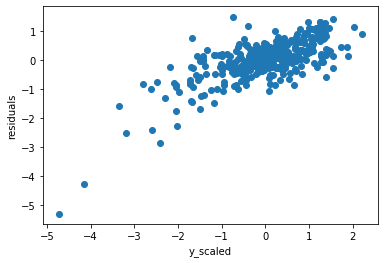

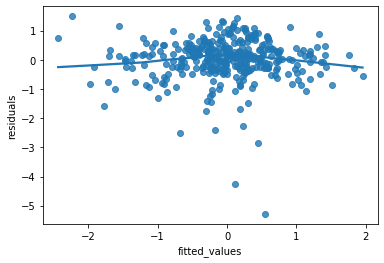

Mean of residuals 0.014503774968696976
RMSE: 0.718879


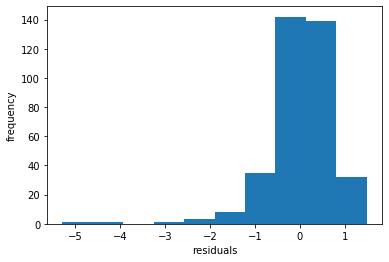

----
Het-Breuschpagan for homogenity:
 (10.554211523554672, 0.9707807024992332, 0.4862135668836282, 0.9741655250968079)
Het white for homogenity:
 (244.1441202852307, 0.485359805999369, 0.9933242799715091, 0.524216323363463)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.477
Model:                            WLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     14.78
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           2.23e-36
Time:                        13:57:35   Log-Likelihood:                -403.08
No. Observations:                 362   AIC:                             850.2
Df Residuals:                     340   BIC:                             935.8
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0016      0.113     -0.014      0.989      -0.223       0.220
age_log2                   0.2491      0.041      6.018      0.000       0.168       0.331
credit_card_days           0.3159      0.050      6.359      0.000       0.218       0.414
solvency_log2             -0.2392      0.046     -5.253      0.000      -0.329      -0.150
giro_days                  0.1216      0.047      2.585      0.010       0.029       0.214
secured_loan_log2          0.2223      0.044      5.038      0.000       0.136       0.309
finance_year_log2         -0.1913      0.052     -3.650      0.000      -0.294      -0.088
relocation_log2           -0.1233      0.041     -2.991      0.003      -0.204      -0.042
credit_card_**2           -0.0698      0.047     -1.479      0.140      -0.163       0.023
unsecured_loan_**3        -0.0473      0.045     -1.062      0.289      -0.135       0.040
telecom                   -0.0601      0.044     -1.367      0.172      -0.147       0.026
credit_days_**3           -0.0412      0.043     -0.956      0.340      -0.126       0.044
giro_**3                  -0.0662      0.043     -1.535      0.126      -0.151       0.019
business_relation_log2    -0.0620      0.040     -1.548      0.122      -0.141       0.017
conditions_log2           -0.0586      0.048     -1.225      0.221      -0.153       0.035
identity_**3              -0.1040      0.047     -2.230      0.026      -0.196      -0.012
monthlyIncome              0.0597      0.044      1.359      0.175      -0.027       0.146
global_credit_log2         0.0539      0.044      1.215      0.225      -0.033       0.141
banking_connection_**3     0.0273      0.041      0.668      0.505      -0.053       0.108
female                     0.0251      0.133      0.189      0.850      -0.236       0.286
mailOrder                 -0.0219      0.117     -0.187      0.852      -0.252       0.208
east                       0.0200      0.110      0.181      0.856      -0.196       0.236
==============================================================================
Omnibus:                      176.162   Durbin-Watson:                   2.149
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1349.653
Skew:                          -1.892   Prob(JB):                    8.45e-294
Kurtosis:                      11.670   Cond. No.                         7.35
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [68]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), df_data.age.apply(np.log).std(), linreg.params[1]))

spc = get_semi_partial_corr(y_scaled, X_scaled[variable], X_scaled.drop([variable, "weight"], axis=1))
print("Semi-Partial Coefficient: %f\nDifference to regression coefficient: %f"%(spc, spc - linreg.params[1]))

Unit influence of variable: 79.827766

Semi-Partial Coefficient: 0.227864
Difference to regression coefficient: -0.021257


In [69]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

## Sex

In [70]:
table2 = pd.read_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_sex.csv", sep=";")

In [71]:
table2 = prepare_type(table2)

In [72]:
variable = "female"

### Banken - Version 1

In [73]:
domain = "Banken"

In [74]:
# As an example we use banken V1
version = 1

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

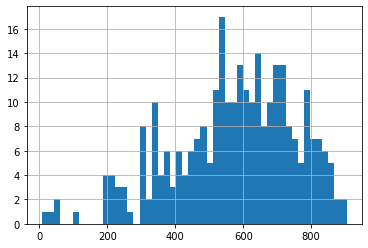

In [75]:
df_data["score"].hist(bins=50)
plt.show()
plt.close()

"""df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(1000-x)*100)
df_data["score"].hist(bins=50)
plt.show()
plt.close()""";

In [76]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [77]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [78]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [79]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(289, 25)
(289, 25)


(289, 2) (289,)


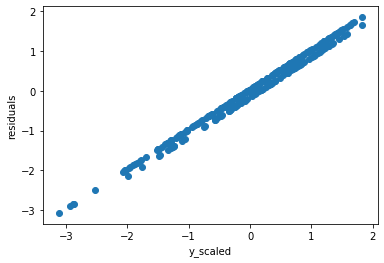

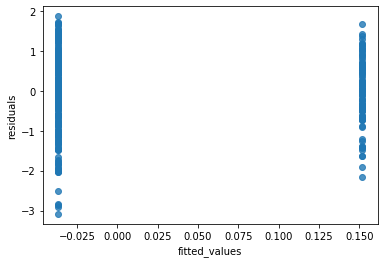

Mean of residuals -0.022769944397659607
RMSE: 0.995063


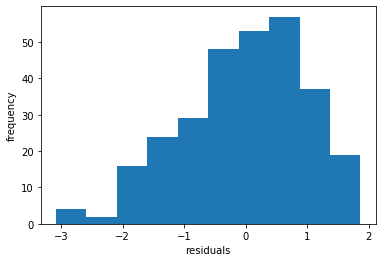

----
Het-Breuschpagan for homogenity:
 (6.7964913520053045, 0.00913371935539005, 6.912008384908462, 0.009023232038166917)
Het white for homogenity:
 (6.7964913520052725, 0.009133719355390205, 6.9120083849083995, 0.009023232038167107)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.010
Model:                            WLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.830
Date:                Sat, 24 Aug 2019   Prob (F-statistic):             0.0936
Time:                        13:59:56   Log-Likelihood:                -413.55
No. Observations:                 289   AIC:                             831.1
Df Residuals:                     287   BIC:                             838.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0366      0.079     -0.462      0.645      -0.193       0.119
female         0.1885      0.112      1.682      0.094      -0.032       0.409
==============================================================================
Omnibus:                        8.059   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.250
Skew:                          -0.414   Prob(JB):                       0.0162
Kurtosis:                       2.979   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [81]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 34.214924



In [82]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [83]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(289, 21) (289,)


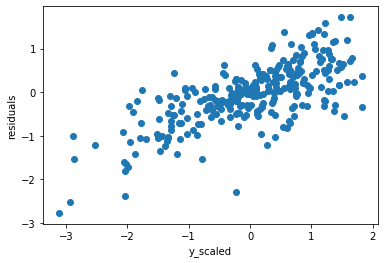

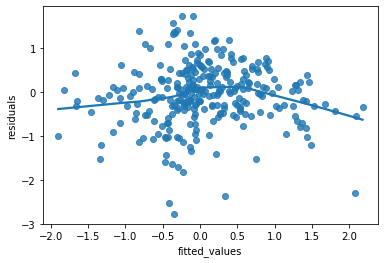

Mean of residuals -0.058978525372870495
RMSE: 0.701817


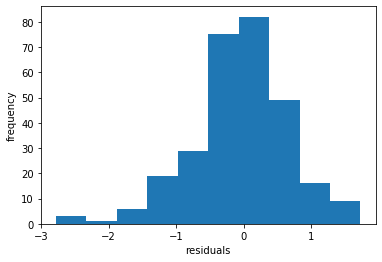

----
Het-Breuschpagan for homogenity:
 (15.526200419182784, 0.745548769669762, 0.760771547168144, 0.7595447324517502)
Het white for homogenity:
 (159.28846228295254, 0.98457109690317, 0.5403291383175689, 0.9997960091456242)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.535
Model:                            WLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     15.44
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           5.04e-34
Time:                        14:00:17   Log-Likelihood:                -304.20
No. Observations:                 289   AIC:                             650.4
Df Residuals:                     268   BIC:                             727.4
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0725      0.101     -0.716      0.475      -0.272       0.127
age                        0.2844      0.058      4.932      0.000       0.171       0.398
credit_card_days           0.4316      0.054      7.997      0.000       0.325       0.538
relocation                 0.0021      0.046      0.044      0.965      -0.089       0.094
solvency_log2             -0.3914      0.046     -8.422      0.000      -0.483      -0.300
finance_year_**2          -0.1322      0.043     -3.055      0.002      -0.217      -0.047
mailOrder                  0.1322      0.110      1.204      0.230      -0.084       0.348
secured_loan_**2          -0.0292      0.054     -0.540      0.590      -0.136       0.077
giro_days                  0.1147      0.062      1.851      0.065      -0.007       0.237
credit_card_**2           -0.1008      0.053     -1.885      0.060      -0.206       0.004
conditions_**2            -0.0086      0.083     -0.104      0.918      -0.171       0.154
giro                       0.0131      0.069      0.191      0.849      -0.122       0.148
unsecured_loan_**3        -0.0811      0.052     -1.572      0.117      -0.183       0.020
identity_**2              -0.0278      0.046     -0.599      0.550      -0.119       0.064
credit_days_log2          -0.0203      0.060     -0.340      0.734      -0.138       0.097
telecom_log2               0.0301      0.044      0.685      0.494      -0.056       0.117
global_credit_**2         -0.0009      0.065     -0.014      0.989      -0.129       0.127
banking_connection_**2     0.0450      0.048      0.938      0.349      -0.049       0.139
east                       0.0853      0.096      0.887      0.376      -0.104       0.275
business_relation_**2     -0.0194      0.047     -0.415      0.678      -0.112       0.073
monthlyIncome              0.0095      0.050      0.191      0.849      -0.089       0.108
==============================================================================
Omnibus:                        7.829   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.020   Jarque-Bera (JB):               10.644
Skew:                          -0.197   Prob(JB):                      0.00488
Kurtosis:                       3.854   Cond. No.                         6.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [85]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [86]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(289, 22) (289,)


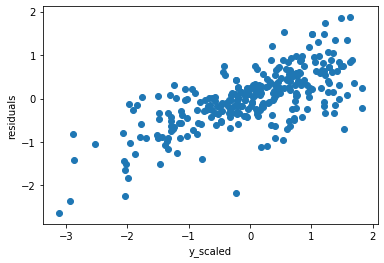

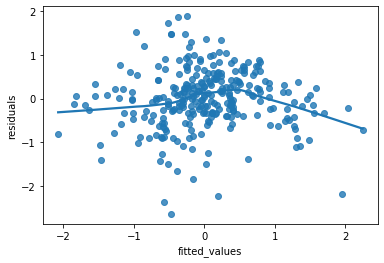

Mean of residuals -0.006661118487026397
RMSE: 0.686396


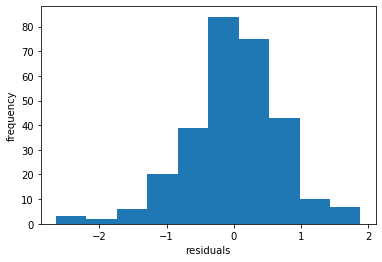

----
Het-Breuschpagan for homogenity:
 (22.12058684434121, 0.392589666362051, 1.0538372292604865, 0.3990855280958802)
Het white for homogenity:
 (171.2232999621718, 0.9857870313429496, 0.5027145180434519, 0.9999302859758025)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.557
Model:                            WLS   Adj. R-squared:                  0.522
Method:                 Least Squares   F-statistic:                     15.96
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           5.53e-36
Time:                        14:00:24   Log-Likelihood:                -297.42
No. Observations:                 289   AIC:                             638.8
Df Residuals:                     267   BIC:                             719.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1977      0.105     -1.882      0.061      -0.404       0.009
age                        0.2836      0.056      5.026      0.000       0.173       0.395
credit_card_days           0.4371      0.053      8.272      0.000       0.333       0.541
relocation             -2.969e-05      0.046     -0.001      0.999      -0.090       0.090
solvency_log2             -0.3909      0.045     -8.595      0.000      -0.480      -0.301
female                     0.2841      0.079      3.581      0.000       0.128       0.440
finance_year_**2          -0.1382      0.042     -3.260      0.001      -0.222      -0.055
mailOrder                  0.1181      0.107      1.099      0.273      -0.093       0.330
secured_loan_**2          -0.0121      0.053     -0.227      0.820      -0.117       0.093
giro_days                  0.1228      0.061      2.023      0.044       0.003       0.242
credit_card_**2           -0.1030      0.052     -1.969      0.050      -0.206     1.4e-05
conditions_**2             0.0016      0.081      0.020      0.984      -0.158       0.161
giro                       0.0169      0.067      0.252      0.801      -0.115       0.149
unsecured_loan_**3        -0.0917      0.051     -1.813      0.071      -0.191       0.008
identity_**2              -0.0374      0.045     -0.821      0.412      -0.127       0.052
credit_days_log2          -0.0275      0.059     -0.470      0.639      -0.143       0.088
telecom_log2               0.0306      0.043      0.710      0.478      -0.054       0.115
global_credit_**2          0.0067      0.064      0.104      0.917      -0.119       0.132
banking_connection_**2     0.0472      0.047      1.006      0.315      -0.045       0.140
east                       0.0661      0.094      0.701      0.484      -0.120       0.252
business_relation_**2     -0.0107      0.046     -0.234      0.815      -0.101       0.080
monthlyIncome              0.0030      0.049      0.061      0.952      -0.093       0.099
==============================================================================
Omnibus:                       11.374   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.208
Skew:                          -0.312   Prob(JB):                     0.000499
Kurtosis:                       3.935   Cond. No.                         6.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [87]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [88]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[5]))

Unit influence of variable: 51.573704



In [89]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Banken, Version 2

In [90]:
variable = "female"

In [91]:
# As an example we use banken V1
version = 2

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

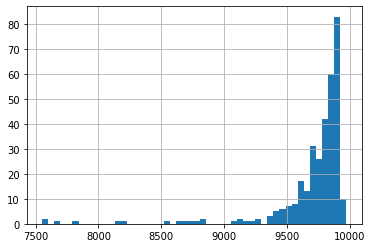

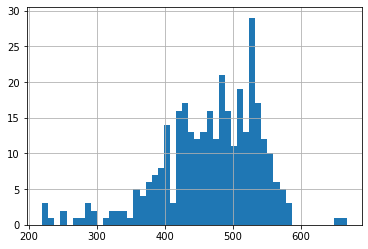

In [92]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)
df_data["score"].hist(bins=50)
plt.show()

In [93]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [94]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [95]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [96]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(331, 25)
(331, 25)


(331, 2) (331,)


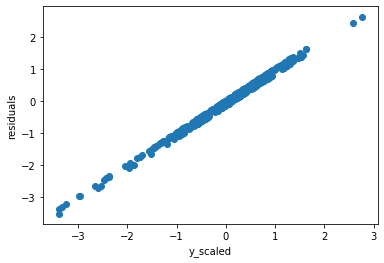

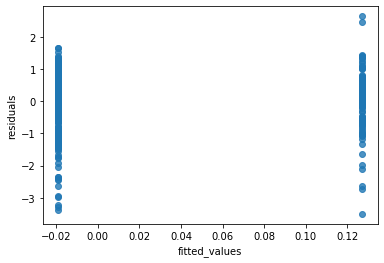

Mean of residuals -0.026949389325007594
RMSE: 0.996817


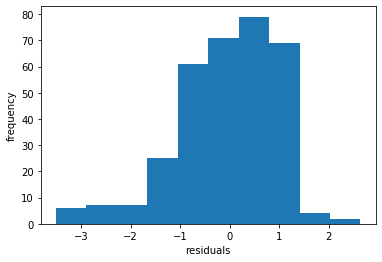

----
Het-Breuschpagan for homogenity:
 (0.14449537205248875, 0.7038522808869061, 0.14368501276326945, 0.704889266954078)
Het white for homogenity:
 (0.14449537205248875, 0.7038522808869061, 0.14368501276326945, 0.704889266954078)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.006
Model:                            WLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.847
Date:                Sat, 24 Aug 2019   Prob (F-statistic):              0.175
Time:                        14:01:09   Log-Likelihood:                -481.11
No. Observations:                 331   AIC:                             966.2
Df Residuals:                     329   BIC:                             973.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0190      0.076     -0.250      0.803      -0.169       0.131
female         0.1462      0.108      1.359      0.175      -0.065       0.358
==============================================================================
Omnibus:                       40.405   Durbin-Watson:                   1.856
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.553
Skew:                          -0.678   Prob(JB):                     1.44e-17
Kurtosis:                       4.945   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [97]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [98]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 10.640177



In [99]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [100]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(331, 21) (331,)


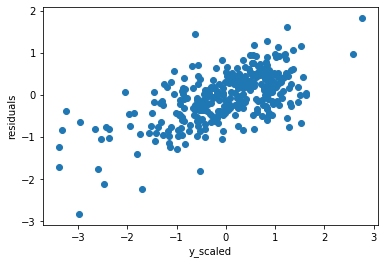

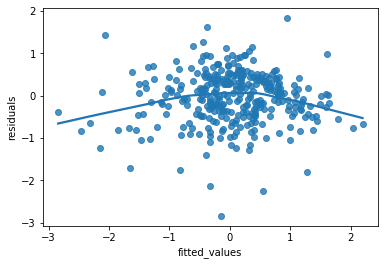

Mean of residuals -0.04417720608149422
RMSE: 0.615563


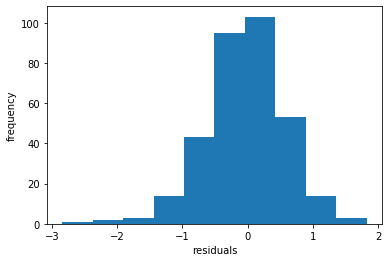

----
Het-Breuschpagan for homogenity:
 (19.921534740978778, 0.46284763733873024, 0.9926234791857439, 0.4708017160182306)
Het white for homogenity:
 (141.06470203395253, 0.9999602933221946, 0.40796126685764683, 0.999999992902043)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.606
Model:                            WLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     23.80
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           5.04e-51
Time:                        14:01:24   Log-Likelihood:                -328.06
No. Observations:                 331   AIC:                             698.1
Df Residuals:                     310   BIC:                             778.0
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0641      0.084     -0.760      0.448      -0.230       0.102
age_log2                   0.3016      0.049      6.184      0.000       0.206       0.398
credit_card_days_log2      0.5285      0.068      7.776      0.000       0.395       0.662
giro_days                  0.3168      0.053      5.965      0.000       0.212       0.421
giro                      -0.2948      0.058     -5.072      0.000      -0.409      -0.180
solvency                  -0.3247      0.040     -8.169      0.000      -0.403      -0.246
unsecured_loan_log2       -0.1630      0.047     -3.444      0.001      -0.256      -0.070
telecom                   -0.1294      0.038     -3.450      0.001      -0.203      -0.056
relocation                -0.0841      0.041     -2.031      0.043      -0.166      -0.003
conditions_log2           -0.0802      0.048     -1.669      0.096      -0.175       0.014
credit_card               -0.1615      0.066     -2.443      0.015      -0.291      -0.031
finance_year_log2         -0.0226      0.050     -0.457      0.648      -0.120       0.075
secured_loan_log2          0.0232      0.041      0.567      0.571      -0.057       0.104
business_relation         -0.0451      0.035     -1.274      0.204      -0.115       0.025
identity_**3              -0.0391      0.039     -0.991      0.322      -0.117       0.039
east                       0.0269      0.085      0.319      0.750      -0.139       0.193
global_credit             -0.0503      0.045     -1.110      0.268      -0.140       0.039
banking_connection_**3    -0.0444      0.048     -0.922      0.357      -0.139       0.050
credit_days_**3           -0.0029      0.045     -0.064      0.949      -0.091       0.085
monthlyIncome             -0.0515      0.044     -1.182      0.238      -0.137       0.034
mailOrder                  0.1261      0.091      1.389      0.166      -0.053       0.305
==============================================================================
Omnibus:                       19.225   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.326
Skew:                          -0.220   Prob(JB):                     8.72e-11
Kurtosis:                       4.779   Cond. No.                         6.49
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [101]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [102]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [103]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(331, 22) (331,)


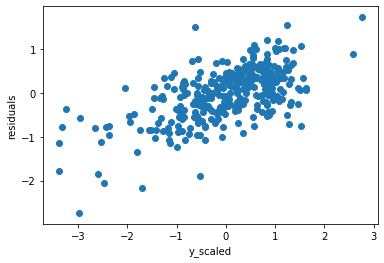

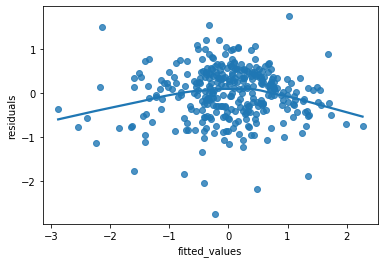

Mean of residuals -0.017549630703492088
RMSE: 0.609270


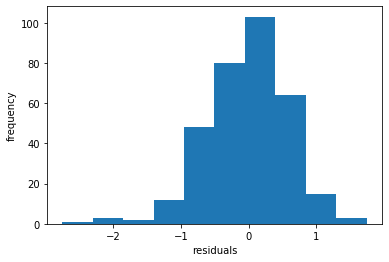

----
Het-Breuschpagan for homogenity:
 (21.788550586404092, 0.4117814917242162, 1.0368405155647533, 0.41814290842976226)
Het white for homogenity:
 (158.41900485735727, 0.9998304305546732, 0.41651023650237595, 0.9999999737515529)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.611
Model:                            WLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     23.13
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           3.03e-51
Time:                        14:01:28   Log-Likelihood:                -325.71
No. Observations:                 331   AIC:                             695.4
Df Residuals:                     309   BIC:                             779.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.1296      0.090     -1.448      0.149      -0.306       0.047
age_log2                   0.3015      0.049      6.215      0.000       0.206       0.397
credit_card_days_log2      0.5286      0.068      7.820      0.000       0.396       0.662
giro_days                  0.3164      0.053      5.988      0.000       0.212       0.420
giro                      -0.2857      0.058     -4.929      0.000      -0.400      -0.172
solvency                  -0.3320      0.040     -8.367      0.000      -0.410      -0.254
unsecured_loan_log2       -0.1587      0.047     -3.368      0.001      -0.251      -0.066
female                     0.1490      0.071      2.103      0.036       0.010       0.288
telecom                   -0.1280      0.037     -3.430      0.001      -0.201      -0.055
relocation                -0.0879      0.041     -2.132      0.034      -0.169      -0.007
conditions_log2           -0.0745      0.048     -1.557      0.120      -0.169       0.020
credit_card               -0.1665      0.066     -2.532      0.012      -0.296      -0.037
finance_year_log2         -0.0233      0.049     -0.473      0.637      -0.120       0.074
secured_loan_log2          0.0251      0.041      0.616      0.538      -0.055       0.105
business_relation         -0.0496      0.035     -1.407      0.161      -0.119       0.020
identity_**3              -0.0305      0.039     -0.773      0.440      -0.108       0.047
east                       0.0244      0.084      0.290      0.772      -0.141       0.190
global_credit             -0.0534      0.045     -1.184      0.237      -0.142       0.035
banking_connection_**3    -0.0383      0.048     -0.799      0.425      -0.133       0.056
credit_days_**3           -0.0033      0.044     -0.074      0.941      -0.091       0.084
monthlyIncome             -0.0548      0.043     -1.264      0.207      -0.140       0.030
mailOrder                  0.1170      0.090      1.294      0.197      -0.061       0.295
==============================================================================
Omnibus:                       26.539   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.753
Skew:                          -0.411   Prob(JB):                     2.88e-13
Kurtosis:                       4.874   Cond. No.                         6.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [104]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [105]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[7]))

Unit influence of variable: 10.844532



In [106]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Banken, Version 3

In [107]:
variable = "female"

In [108]:
version = 3

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

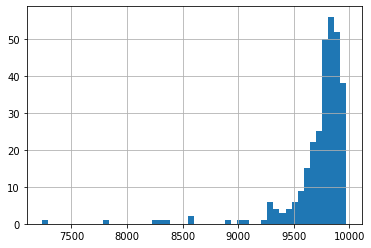

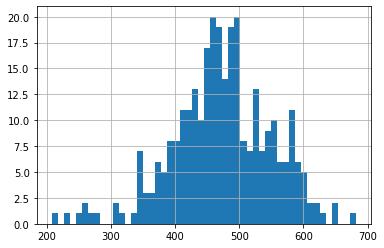

In [109]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)

df_data["score"].hist(bins=50)
plt.show()

In [110]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [111]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [112]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [113]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(301, 25)
(301, 25)


(301, 2) (301,)


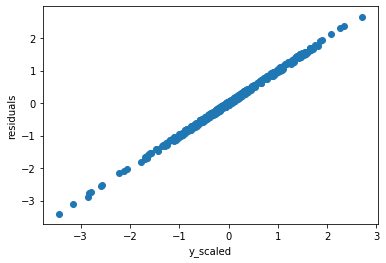

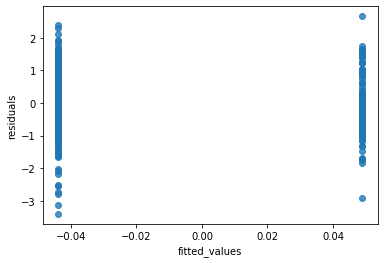

Mean of residuals 0.013002841395270028
RMSE: 0.999529


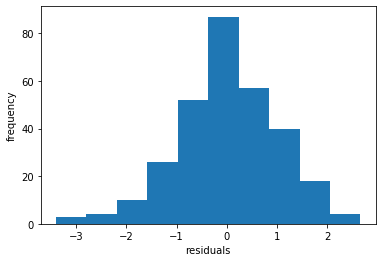

----
Het-Breuschpagan for homogenity:
 (0.8825433619596225, 0.3475060181442793, 0.8792573020641722, 0.34916197297960294)
Het white for homogenity:
 (0.8825433619596225, 0.3475060181442793, 0.8792573020641722, 0.34916197297960294)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.002
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6876
Date:                Sat, 24 Aug 2019   Prob (F-statistic):              0.408
Time:                        14:02:00   Log-Likelihood:                -436.11
No. Observations:                 301   AIC:                             876.2
Df Residuals:                     299   BIC:                             883.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0439      0.079     -0.554      0.580      -0.200       0.112
female         0.0929      0.112      0.829      0.408      -0.128       0.313
==============================================================================
Omnibus:                        8.408   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               11.264
Skew:                          -0.218   Prob(JB):                      0.00358
Kurtosis:                       3.842   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [114]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [115]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 7.175360



In [116]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [117]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(301, 21) (301,)


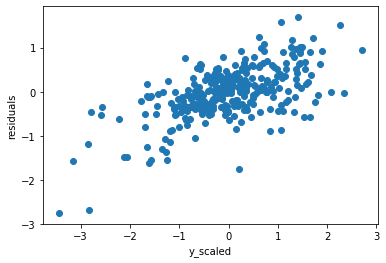

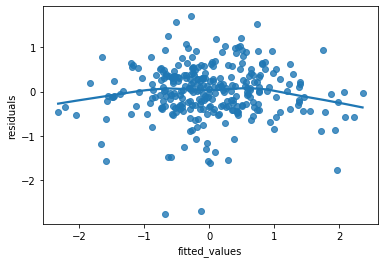

Mean of residuals -0.005837852432270259
RMSE: 0.599514


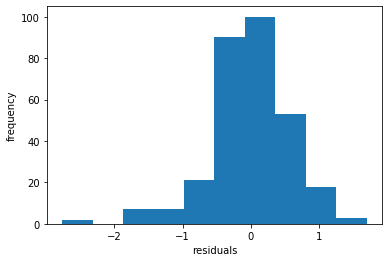

----
Het-Breuschpagan for homogenity:
 (12.64089080071129, 0.8922548607103974, 0.6137224924205539, 0.9017975197534834)
Het white for homogenity:
 (119.9351631222998, 0.9999997166856754, 0.3022546880852215, 0.9999999999995233)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.670
Model:                            WLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     28.42
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           8.67e-56
Time:                        14:02:16   Log-Likelihood:                -269.62
No. Observations:                 301   AIC:                             581.2
Df Residuals:                     280   BIC:                             659.1
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0889      0.093     -0.952      0.342      -0.273       0.095
age_log2                   0.3692      0.047      7.785      0.000       0.276       0.463
credit_card_days           0.3002      0.051      5.849      0.000       0.199       0.401
solvency_log2             -0.3298      0.040     -8.187      0.000      -0.409      -0.250
giro_days                  0.1499      0.045      3.330      0.001       0.061       0.238
secured_loan_log2          0.1757      0.041      4.325      0.000       0.096       0.256
finance_year_log2         -0.1397      0.043     -3.285      0.001      -0.223      -0.056
relocation_log2           -0.0724      0.043     -1.688      0.093      -0.157       0.012
credit_card_**2           -0.0926      0.042     -2.201      0.029      -0.175      -0.010
unsecured_loan_**3        -0.0019      0.035     -0.054      0.957      -0.070       0.066
telecom                   -0.0681      0.037     -1.825      0.069      -0.141       0.005
credit_days_**3           -0.0365      0.043     -0.857      0.392      -0.120       0.047
giro_**3                  -0.0405      0.051     -0.792      0.429      -0.141       0.060
business_relation_log2    -0.0724      0.036     -2.038      0.042      -0.142      -0.002
conditions_log2           -0.0153      0.042     -0.362      0.717      -0.098       0.068
identity_**3              -0.0125      0.042     -0.298      0.766      -0.095       0.070
monthlyIncome              0.0024      0.041      0.059      0.953      -0.079       0.083
global_credit_log2        -0.0222      0.044     -0.499      0.618      -0.110       0.065
banking_connection_**3    -0.0027      0.039     -0.069      0.945      -0.079       0.073
mailOrder                  0.1198      0.100      1.201      0.231      -0.077       0.316
east                      -0.0377      0.078     -0.485      0.628      -0.191       0.115
==============================================================================
Omnibus:                       15.309   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.995
Skew:                          -0.293   Prob(JB):                     1.37e-06
Kurtosis:                       4.345   Cond. No.                         7.03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [118]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [119]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [120]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(301, 22) (301,)


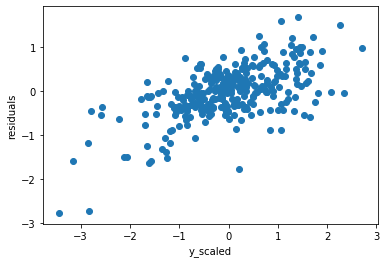

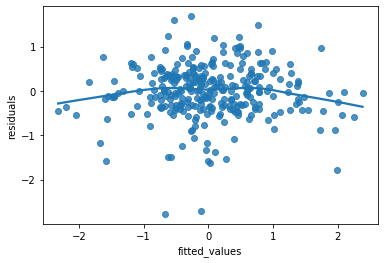

Mean of residuals -0.011178576251587727
RMSE: 0.599530


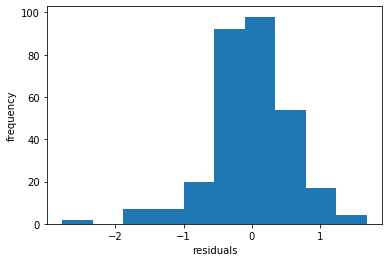

----
Het-Breuschpagan for homogenity:
 (13.908789300363798, 0.8734851382783347, 0.643656767668045, 0.8843893944981851)
Het white for homogenity:
 (129.31115444501816, 0.9999998622308531, 0.2692332700885729, 0.999999999999989)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.670
Model:                            WLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     27.00
Date:                Sat, 24 Aug 2019   Prob (F-statistic):           4.19e-55
Time:                        14:02:20   Log-Likelihood:                -269.50
No. Observations:                 301   AIC:                             583.0
Df Residuals:                     279   BIC:                             664.5
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.0712      0.100     -0.709      0.479      -0.269       0.126
age_log2                   0.3708      0.048      7.789      0.000       0.277       0.465
credit_card_days           0.2987      0.051      5.804      0.000       0.197       0.400
solvency_log2             -0.3305      0.040     -8.187      0.000      -0.410      -0.251
giro_days                  0.1501      0.045      3.330      0.001       0.061       0.239
secured_loan_log2          0.1765      0.041      4.335      0.000       0.096       0.257
finance_year_log2         -0.1382      0.043     -3.237      0.001      -0.222      -0.054
relocation_log2           -0.0724      0.043     -1.686      0.093      -0.157       0.012
credit_card_**2           -0.0916      0.042     -2.172      0.031      -0.175      -0.009
unsecured_loan_**3        -0.0001      0.035     -0.004      0.997      -0.069       0.069
telecom                   -0.0672      0.037     -1.798      0.073      -0.141       0.006
credit_days_**3           -0.0354      0.043     -0.830      0.407      -0.119       0.049
giro_**3                  -0.0424      0.051     -0.826      0.410      -0.143       0.059
business_relation_log2    -0.0725      0.036     -2.038      0.043      -0.142      -0.002
conditions_log2           -0.0180      0.043     -0.422      0.673      -0.102       0.066
identity_**3              -0.0139      0.042     -0.332      0.740      -0.096       0.069
monthlyIncome              0.0026      0.041      0.062      0.951      -0.079       0.084
global_credit_log2        -0.0239      0.045     -0.535      0.593      -0.112       0.064
banking_connection_**3    -0.0039      0.039     -0.100      0.921      -0.080       0.072
female                    -0.0334      0.069     -0.484      0.629      -0.169       0.102
mailOrder                  0.1182      0.100      1.183      0.238      -0.078       0.315
east                      -0.0374      0.078     -0.480      0.632      -0.191       0.116
==============================================================================
Omnibus:                       15.137   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.606
Skew:                          -0.275   Prob(JB):                     1.01e-06
Kurtosis:                       4.378   Cond. No.                         7.23
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [121]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [122]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[-3]))

Unit influence of variable: -2.578066



In [123]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

## East_west

In [124]:
table2 = pd.read_csv(data_path + "datasets_v2/20190704__analysis_dataset_matching_east_west.csv", sep=";")

In [125]:
table2 = prepare_type(table2)

In [126]:
variable = "east"

### Banken - Version 1

In [127]:
domain = "Banken"

In [128]:
# As an example we use banken V1
version = 1

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

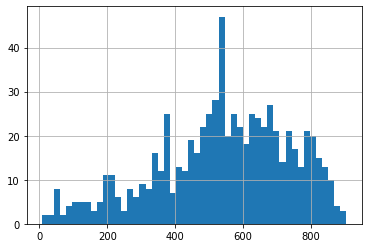

In [129]:
df_data["score"].hist(bins=50)
plt.show()
plt.close()

"""df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(1000-x)*100)
df_data["score"].hist(bins=50)
plt.show()
plt.close()""";

In [130]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [131]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [132]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [133]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(700, 25)
(700, 25)


(700, 2) (700,)


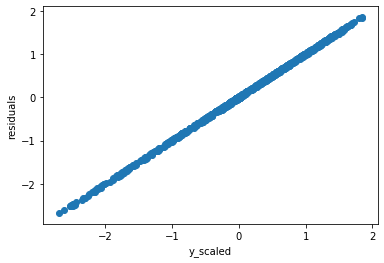

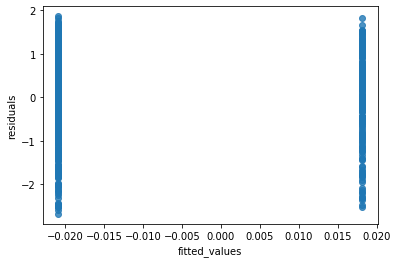

Mean of residuals 0.007875606396522601
RMSE: 0.999964


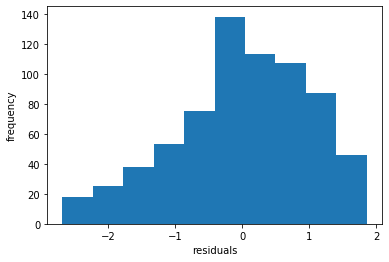

----
Het-Breuschpagan for homogenity:
 (3.0229915056999346, 0.0820919079179696, 3.027428516669396, 0.08230842603708169)
Het white for homogenity:
 (3.0229915056999346, 0.0820919079179696, 3.027428516669396, 0.08230842603708169)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2738
Date:                Sat, 24 Aug 2019   Prob (F-statistic):              0.601
Time:                        14:02:50   Log-Likelihood:                -1024.3
No. Observations:                 700   AIC:                             2053.
Df Residuals:                     698   BIC:                             2062.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0209      0.053     -0.396      0.692      -0.124       0.083
east           0.0390      0.075      0.523      0.601      -0.107       0.185
==============================================================================
Omnibus:                       35.425   Durbin-Watson:                   1.843
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               39.446
Skew:                          -0.567   Prob(JB):                     2.72e-09
Kurtosis:                       3.261   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [134]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [135]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 7.692192



In [136]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [137]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(700, 21) (700,)


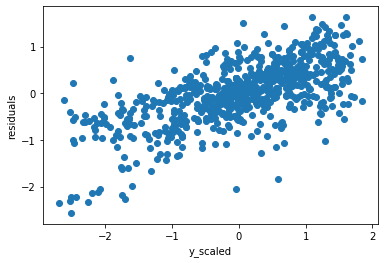

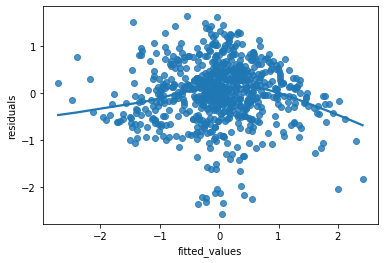

Mean of residuals -0.0033256776729808047
RMSE: 0.665527


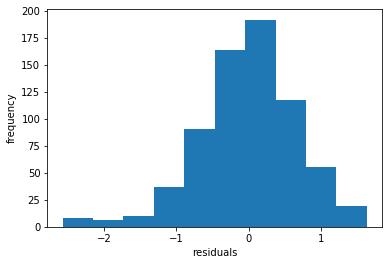

----
Het-Breuschpagan for homogenity:
 (22.721981539188818, 0.3026511411491914, 1.1389876125148397, 0.30369575787395264)
Het white for homogenity:
 (143.58274370005668, 0.9999973454503756, 0.5330742660834784, 0.9999999311975675)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.569
Model:                            WLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     44.88
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          7.62e-110
Time:                        14:05:18   Log-Likelihood:                -729.63
No. Observations:                 700   AIC:                             1501.
Df Residuals:                     679   BIC:                             1597.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1074      0.066      1.626      0.104      -0.022       0.237
age                        0.1891      0.032      5.820      0.000       0.125       0.253
credit_card_days           0.3474      0.033     10.501      0.000       0.282       0.412
relocation                -0.0136      0.028     -0.492      0.623      -0.068       0.041
solvency_log2             -0.4890      0.030    -16.394      0.000      -0.548      -0.430
female                     0.1277      0.086      1.480      0.139      -0.042       0.297
finance_year_**2          -0.0455      0.033     -1.371      0.171      -0.111       0.020
mailOrder                 -0.1349      0.072     -1.876      0.061      -0.276       0.006
secured_loan_**2          -0.0635      0.032     -1.996      0.046      -0.126      -0.001
giro_days                  0.1503      0.036      4.166      0.000       0.079       0.221
credit_card_**2            0.0114      0.033      0.346      0.730      -0.053       0.076
conditions_**2            -0.0934      0.029     -3.262      0.001      -0.150      -0.037
giro                      -0.0834      0.040     -2.107      0.035      -0.161      -0.006
unsecured_loan_**3         0.0034      0.031      0.110      0.912      -0.057       0.064
identity_**2              -0.0062      0.026     -0.233      0.816      -0.058       0.046
credit_days_log2           0.0181      0.035      0.520      0.604      -0.050       0.086
telecom_log2              -0.0290      0.027     -1.092      0.275      -0.081       0.023
global_credit_**2         -0.0063      0.031     -0.202      0.840      -0.068       0.055
banking_connection_**2    -0.0070      0.025     -0.281      0.779      -0.056       0.042
business_relation_**2      0.0113      0.026      0.439      0.661      -0.039       0.062
monthlyIncome              0.0796      0.030      2.697      0.007       0.022       0.138
==============================================================================
Omnibus:                       64.464   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              132.885
Skew:                          -0.554   Prob(JB):                     1.39e-29
Kurtosis:                       4.825   Cond. No.                         7.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [139]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [140]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(700, 22) (700,)


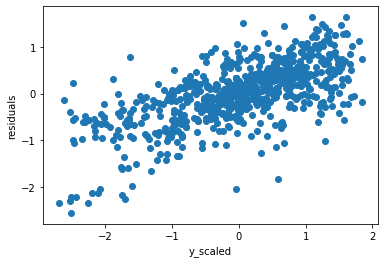

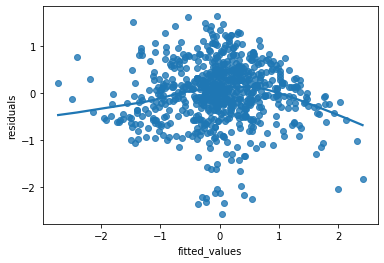

Mean of residuals -0.0007484754562338358
RMSE: 0.665470


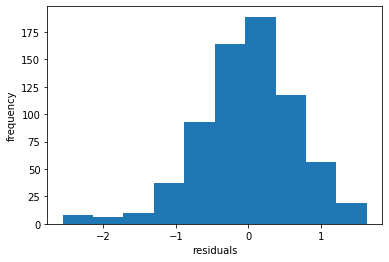

----
Het-Breuschpagan for homogenity:
 (25.66686814489456, 0.2194370535925855, 1.2288780313307002, 0.21890569528446413)
Het white for homogenity:
 (157.83369553116097, 0.9999986815484865, 0.5261146184827192, 0.9999999834065055)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.569
Model:                            WLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     42.69
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          4.94e-109
Time:                        14:05:22   Log-Likelihood:                -729.58
No. Observations:                 700   AIC:                             1503.
Df Residuals:                     678   BIC:                             1603.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.1006      0.070      1.441      0.150      -0.036       0.238
age                        0.1891      0.033      5.816      0.000       0.125       0.253
credit_card_days           0.3469      0.033     10.465      0.000       0.282       0.412
relocation                -0.0137      0.028     -0.497      0.619      -0.068       0.041
solvency_log2             -0.4889      0.030    -16.382      0.000      -0.548      -0.430
female                     0.1277      0.086      1.479      0.140      -0.042       0.297
finance_year_**2          -0.0452      0.033     -1.362      0.174      -0.110       0.020
mailOrder                 -0.1358      0.072     -1.886      0.060      -0.277       0.006
secured_loan_**2          -0.0635      0.032     -1.995      0.046      -0.126      -0.001
giro_days                  0.1506      0.036      4.170      0.000       0.080       0.222
credit_card_**2            0.0113      0.033      0.345      0.730      -0.053       0.076
conditions_**2            -0.0935      0.029     -3.265      0.001      -0.150      -0.037
giro                      -0.0838      0.040     -2.114      0.035      -0.162      -0.006
unsecured_loan_**3         0.0032      0.031      0.105      0.917      -0.058       0.064
identity_**2              -0.0059      0.026     -0.222      0.824      -0.058       0.046
credit_days_log2           0.0181      0.035      0.519      0.604      -0.050       0.086
telecom_log2              -0.0289      0.027     -1.090      0.276      -0.081       0.023
global_credit_**2         -0.0060      0.031     -0.193      0.847      -0.067       0.055
banking_connection_**2    -0.0071      0.025     -0.284      0.776      -0.056       0.042
east                       0.0153      0.050      0.307      0.759      -0.083       0.113
business_relation_**2      0.0111      0.026      0.431      0.666      -0.039       0.062
monthlyIncome              0.0795      0.030      2.692      0.007       0.022       0.138
==============================================================================
Omnibus:                       65.137   Durbin-Watson:                   1.831
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              133.904
Skew:                          -0.560   Prob(JB):                     8.38e-30
Kurtosis:                       4.827   Cond. No.                         7.17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [141]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [142]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[-3]))

Unit influence of variable: 3.020899



In [143]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Banken, Version 2

In [144]:
variable = "east"

In [145]:
# As an example we use banken V1
version = 2

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

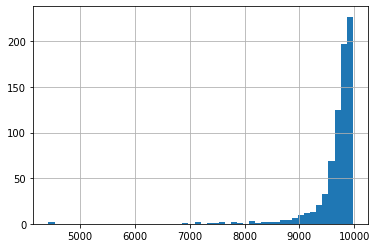

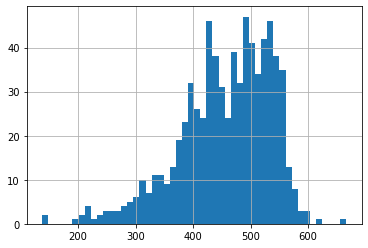

In [146]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)
df_data["score"].hist(bins=50)
plt.show()

In [147]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [148]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [149]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [150]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(743, 25)
(743, 25)


(743, 2) (743,)


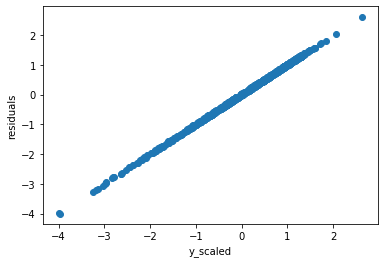

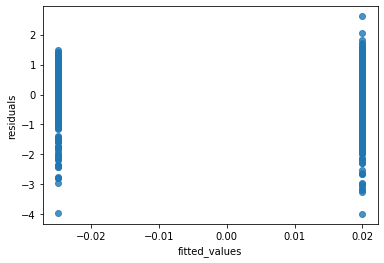

Mean of residuals -0.005450602102638949
RMSE: 0.999873


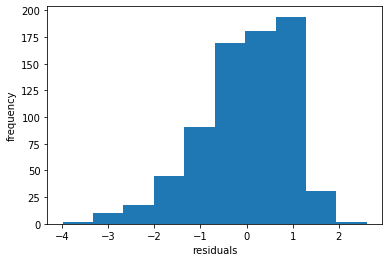

----
Het-Breuschpagan for homogenity:
 (0.08960274977375882, 0.7646827856848801, 0.08937233592113202, 0.7650604432732582)
Het white for homogenity:
 (0.08960274977375882, 0.7646827856848801, 0.08937233592113202, 0.7650604432732582)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3755
Date:                Sat, 24 Aug 2019   Prob (F-statistic):              0.540
Time:                        14:07:21   Log-Likelihood:                -1097.5
No. Observations:                 743   AIC:                             2199.
Df Residuals:                     741   BIC:                             2208.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.052      0.386      0.699      -0.082       0.122
east          -0.0449      0.073     -0.613      0.540      -0.189       0.099
==============================================================================
Omnibus:                      120.186   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              222.299
Skew:                          -0.963   Prob(JB):                     5.35e-49
Kurtosis:                       4.864   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [151]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [152]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: -3.584897



In [153]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [154]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(743, 21) (743,)


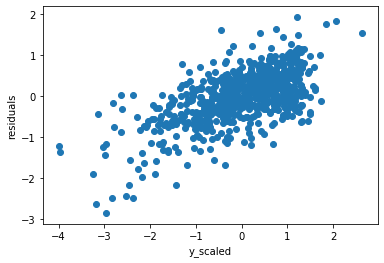

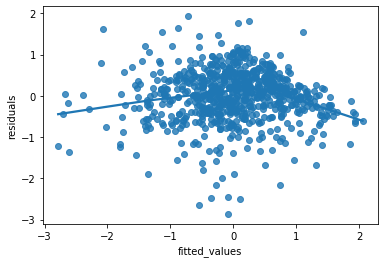

Mean of residuals 0.0008443653928751504
RMSE: 0.637698


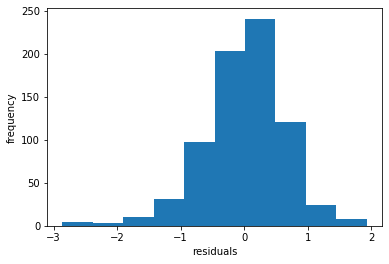

----
Het-Breuschpagan for homogenity:
 (46.1382717875719, 0.0007715371975572773, 2.3901321368356387, 0.0006135734693150602)
Het white for homogenity:
 (161.71515231723637, 0.9996473587571764, 0.6311652553349512, 0.9999584768088943)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.608
Model:                            WLS   Adj. R-squared:                  0.597
Method:                 Least Squares   F-statistic:                     55.94
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          6.97e-132
Time:                        14:07:40   Log-Likelihood:                -750.02
No. Observations:                 743   AIC:                             1542.
Df Residuals:                     722   BIC:                             1639.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0072      0.059      0.122      0.903      -0.108       0.123
age_log2                   0.3301      0.030     10.822      0.000       0.270       0.390
credit_card_days_log2      0.3835      0.043      8.952      0.000       0.299       0.468
giro_days                  0.2428      0.034      7.147      0.000       0.176       0.310
giro                      -0.2243      0.040     -5.642      0.000      -0.302      -0.146
solvency                  -0.3472      0.026    -13.274      0.000      -0.399      -0.296
unsecured_loan_log2       -0.1004      0.027     -3.695      0.000      -0.154      -0.047
female                     0.1521      0.078      1.943      0.052      -0.002       0.306
telecom                   -0.0633      0.024     -2.617      0.009      -0.111      -0.016
relocation                -0.0893      0.026     -3.458      0.001      -0.140      -0.039
conditions_log2           -0.1368      0.028     -4.854      0.000      -0.192      -0.081
credit_card               -0.0927      0.044     -2.110      0.035      -0.179      -0.006
finance_year_log2         -0.0194      0.031     -0.622      0.534      -0.081       0.042
secured_loan_log2          0.0530      0.027      1.977      0.048       0.000       0.106
business_relation         -0.0735      0.026     -2.808      0.005      -0.125      -0.022
identity_**3               0.0066      0.021      0.316      0.752      -0.034       0.047
global_credit             -0.0430      0.025     -1.697      0.090      -0.093       0.007
banking_connection_**3    -0.0047      0.023     -0.209      0.834      -0.049       0.040
credit_days_**3           -0.0169      0.033     -0.505      0.613      -0.083       0.049
monthlyIncome              0.0105      0.028      0.375      0.708      -0.044       0.065
mailOrder                 -0.0266      0.065     -0.412      0.681      -0.153       0.100
==============================================================================
Omnibus:                      122.828   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              325.444
Skew:                          -0.846   Prob(JB):                     2.14e-71
Kurtosis:                       5.765   Cond. No.                         7.10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [156]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [157]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(743, 22) (743,)


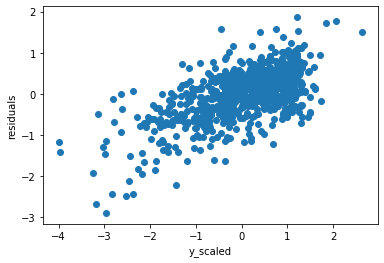

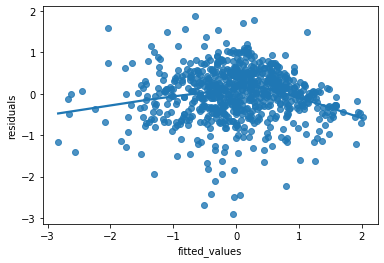

Mean of residuals -0.015470252302969363
RMSE: 0.637022


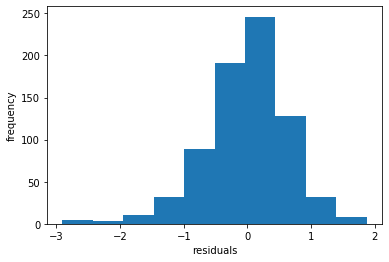

----
Het-Breuschpagan for homogenity:
 (45.212800780583144, 0.0016239755676014133, 2.224612549312812, 0.00133474151063153)
Het white for homogenity:
 (176.11255475224195, 0.9998251605753273, 0.6188262765509653, 0.9999875776068101)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.610
Model:                            WLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     53.68
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          7.59e-132
Time:                        14:07:43   Log-Likelihood:                -747.98
No. Observations:                 743   AIC:                             1540.
Df Residuals:                     721   BIC:                             1641.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0567      0.064      0.889      0.374      -0.068       0.182
age_log2                   0.3331      0.030     10.930      0.000       0.273       0.393
credit_card_days_log2      0.3860      0.043      9.025      0.000       0.302       0.470
giro_days                  0.2413      0.034      7.114      0.000       0.175       0.308
giro                      -0.2232      0.040     -5.626      0.000      -0.301      -0.145
solvency                  -0.3461      0.026    -13.257      0.000      -0.397      -0.295
unsecured_loan_log2       -0.1029      0.027     -3.788      0.000      -0.156      -0.050
female                     0.1487      0.078      1.903      0.057      -0.005       0.302
telecom                   -0.0624      0.024     -2.585      0.010      -0.110      -0.015
relocation                -0.0896      0.026     -3.476      0.001      -0.140      -0.039
conditions_log2           -0.1341      0.028     -4.764      0.000      -0.189      -0.079
credit_card               -0.0925      0.044     -2.110      0.035      -0.179      -0.006
finance_year_log2         -0.0208      0.031     -0.666      0.506      -0.082       0.040
secured_loan_log2          0.0531      0.027      1.983      0.048       0.001       0.106
business_relation         -0.0747      0.026     -2.859      0.004      -0.126      -0.023
identity_**3               0.0047      0.021      0.227      0.820      -0.036       0.046
east                      -0.0931      0.047     -1.990      0.047      -0.185      -0.001
global_credit             -0.0410      0.025     -1.618      0.106      -0.091       0.009
banking_connection_**3    -0.0045      0.022     -0.199      0.843      -0.049       0.040
credit_days_**3           -0.0193      0.033     -0.578      0.564      -0.085       0.046
monthlyIncome              0.0097      0.028      0.347      0.729      -0.045       0.064
mailOrder                 -0.0298      0.064     -0.462      0.644      -0.156       0.097
==============================================================================
Omnibus:                      108.948   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              275.140
Skew:                          -0.771   Prob(JB):                     1.80e-60
Kurtosis:                       5.551   Cond. No.                         7.33
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [158]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [161]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[-6]))

Unit influence of variable: -7.430496



In [162]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)

### Using Banken, Version 3

In [163]:
variable = "east"

In [164]:
version = 3

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

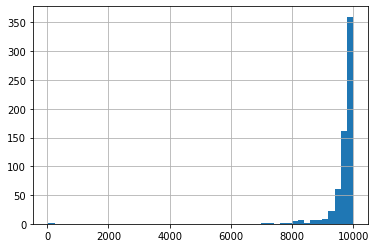

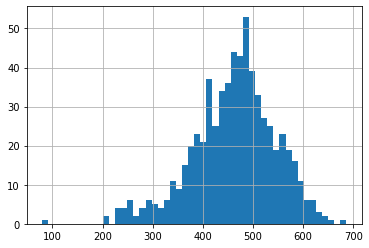

In [165]:
df_data["score"].hist(bins=50)
plt.show()

df_data["score"] = df_data["score"].apply(lambda x: 1000-np.log(10000-x)*100)

df_data["score"].hist(bins=50)
plt.show()

In [166]:
nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_variables = target + nominal + metric

In [167]:
feat_l = pd.read_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", header=None)
feat_l = feat_l[0].values.tolist()

In [168]:
# remove request features because it leads to heterogenous variances
feat_l = [feat for feat in feat_l if "req" not in feat]

In [169]:
X_scaled, y_scaled = create_dataset(df_data, relevant_variables, nominal, metric, target, feat_l)

(646, 25)
(646, 25)


(646, 2) (646,)


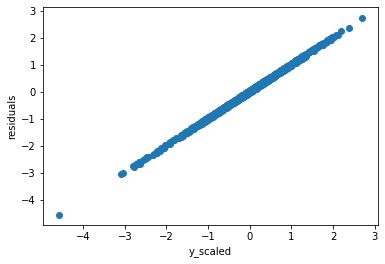

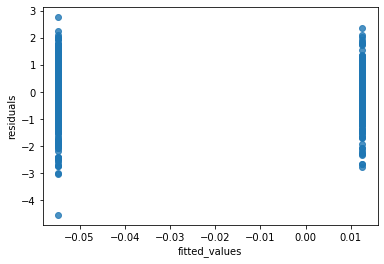

Mean of residuals 0.0322113987029823
RMSE: 1.000739


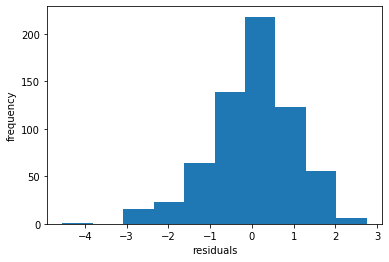

----
Het-Breuschpagan for homogenity:
 (1.076682716999899, 0.29944084186604697, 1.0751412627924508, 0.3001762059645579)
Het white for homogenity:
 (1.0766827169999706, 0.2994408418660309, 1.0751412627925352, 0.3001762059645579)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7346
Date:                Sat, 24 Aug 2019   Prob (F-statistic):              0.392
Time:                        14:08:42   Log-Likelihood:                -951.57
No. Observations:                 646   AIC:                             1907.
Df Residuals:                     644   BIC:                             1916.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0547      0.056     -0.986      0.325      -0.164       0.054
east           0.0673      0.079      0.857      0.392      -0.087       0.221
==============================================================================
Omnibus:                       49.498   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.980
Skew:                          -0.582   Prob(JB):                     2.34e-16
Kurtosis:                       4.148   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [170]:
# ONLY Variable
linreg = do_regression(X_scaled[[variable, "weight"]].copy(), y_scaled)
linreg.summary()

In [171]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[1]))

Unit influence of variable: 5.610046



In [172]:
name = "linear_regression/model_quality_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_predictor.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const", variable], name)

In [173]:
variable_features = [v for v in X_scaled.columns if variable in v]
evaluate_vifs(X_scaled.drop(variable_features + ["weight"], axis=1))

(646, 21) (646,)


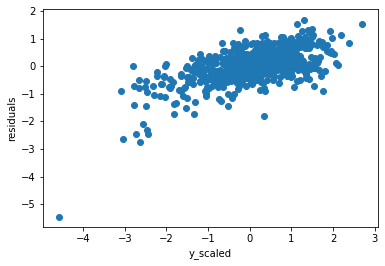

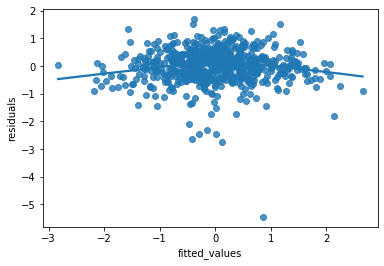

Mean of residuals 0.002285925620655874
RMSE: 0.618092


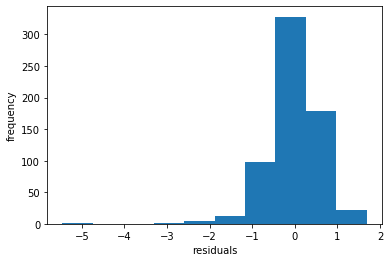

----
Het-Breuschpagan for homogenity:
 (12.071976789732707, 0.9135763077892003, 0.5950979620189731, 0.9174775107427814)
Het white for homogenity:
 (266.63777565842264, 0.04031633495318725, 1.2854902961371837, 0.014272141197624875)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.643
Model:                            WLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     56.30
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          2.67e-125
Time:                        14:08:55   Log-Likelihood:                -619.20
No. Observations:                 646   AIC:                             1280.
Df Residuals:                     625   BIC:                             1374.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0030      0.061      0.049      0.961      -0.116       0.122
age_log2                   0.2336      0.032      7.337      0.000       0.171       0.296
credit_card_days           0.2932      0.032      9.302      0.000       0.231       0.355
solvency_log2             -0.3547      0.028    -12.499      0.000      -0.410      -0.299
giro_days                  0.1655      0.030      5.510      0.000       0.107       0.225
secured_loan_log2          0.2045      0.030      6.879      0.000       0.146       0.263
finance_year_log2         -0.1867      0.029     -6.395      0.000      -0.244      -0.129
relocation_log2           -0.1254      0.027     -4.604      0.000      -0.179      -0.072
credit_card_**2           -0.1185      0.031     -3.803      0.000      -0.180      -0.057
unsecured_loan_**3         0.0127      0.030      0.424      0.672      -0.046       0.072
telecom                   -0.0639      0.025     -2.545      0.011      -0.113      -0.015
credit_days_**3           -0.1089      0.032     -3.413      0.001      -0.172      -0.046
giro_**3                  -0.0030      0.029     -0.102      0.919      -0.060       0.054
business_relation_log2    -0.0510      0.025     -2.046      0.041      -0.100      -0.002
conditions_log2           -0.0382      0.028     -1.371      0.171      -0.093       0.017
identity_**3              -0.0328      0.030     -1.108      0.268      -0.091       0.025
monthlyIncome              0.0696      0.029      2.389      0.017       0.012       0.127
global_credit_log2         0.0902      0.026      3.491      0.001       0.039       0.141
banking_connection_**3     0.0452      0.026      1.768      0.077      -0.005       0.095
female                     0.0200      0.074      0.270      0.788      -0.125       0.165
mailOrder                 -0.0089      0.066     -0.135      0.892      -0.138       0.121
==============================================================================
Omnibus:                      191.835   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1144.348
Skew:                          -1.184   Prob(JB):                    3.22e-249
Kurtosis:                       9.075   Cond. No.                         6.74
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [174]:
# REGRESSION WITHOUT VARIABLE
linreg = do_regression(X_scaled.drop(variable_features, axis=1).copy(), y_scaled)
linreg.summary()

In [175]:
name = "linear_regression/model_quality_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_covariates.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.drop(variable_features+["weight"], axis=1).columns.tolist(), name)

In [176]:
evaluate_vifs(X_scaled.iloc[:,:-1])

(646, 22) (646,)


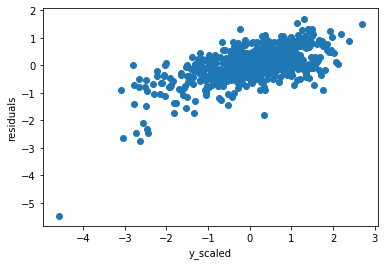

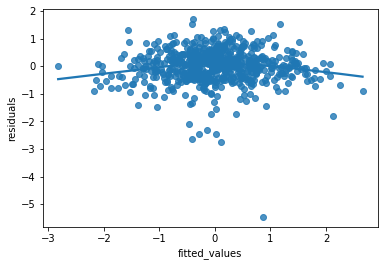

Mean of residuals 4.836775903237408e-06
RMSE: 0.618041


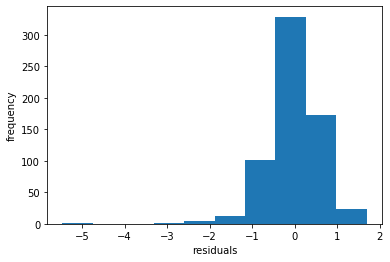

----
Het-Breuschpagan for homogenity:
 (12.674432869263683, 0.9195987396742703, 0.5946573754318232, 0.9235088011006543)
Het white for homogenity:
 (292.98038397848865, 0.02905299383225018, 1.319883331983835, 0.007038598644384472)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.643
Model:                            WLS   Adj. R-squared:                  0.631
Method:                 Least Squares   F-statistic:                     53.54
Date:                Sat, 24 Aug 2019   Prob (F-statistic):          1.95e-124
Time:                        14:08:59   Log-Likelihood:                -619.16
No. Observations:                 646   AIC:                             1282.
Df Residuals:                     624   BIC:                             1381.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0097      0.065      0.149      0.882      -0.118       0.137
age_log2                   0.2336      0.032      7.332      0.000       0.171       0.296
credit_card_days           0.2932      0.032      9.296      0.000       0.231       0.355
solvency_log2             -0.3551      0.028    -12.491      0.000      -0.411      -0.299
giro_days                  0.1660      0.030      5.513      0.000       0.107       0.225
secured_loan_log2          0.2043      0.030      6.864      0.000       0.146       0.263
finance_year_log2         -0.1862      0.029     -6.363      0.000      -0.244      -0.129
relocation_log2           -0.1256      0.027     -4.607      0.000      -0.179      -0.072
credit_card_**2           -0.1188      0.031     -3.808      0.000      -0.180      -0.058
unsecured_loan_**3         0.0121      0.030      0.402      0.688      -0.047       0.071
telecom                   -0.0637      0.025     -2.537      0.011      -0.113      -0.014
credit_days_**3           -0.1088      0.032     -3.405      0.001      -0.171      -0.046
giro_**3                  -0.0032      0.029     -0.109      0.914      -0.060       0.054
business_relation_log2    -0.0507      0.025     -2.032      0.043      -0.100      -0.002
conditions_log2           -0.0378      0.028     -1.356      0.176      -0.093       0.017
identity_**3              -0.0330      0.030     -1.115      0.265      -0.091       0.025
monthlyIncome              0.0699      0.029      2.396      0.017       0.013       0.127
global_credit_log2         0.0900      0.026      3.481      0.001       0.039       0.141
banking_connection_**3     0.0450      0.026      1.759      0.079      -0.005       0.095
female                     0.0208      0.074      0.281      0.779      -0.125       0.166
mailOrder                 -0.0088      0.066     -0.134      0.894      -0.138       0.121
east                      -0.0138      0.048     -0.287      0.774      -0.109       0.081
==============================================================================
Omnibus:                      191.249   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1147.859
Skew:                          -1.178   Prob(JB):                    5.57e-250
Kurtosis:                       9.091   Cond. No.                         6.89
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [177]:
##### REGRESSION WITH ALL
linreg = do_regression(X_scaled.copy(), y_scaled)
linreg.summary()

In [178]:
print("Unit influence of variable: %f\n"%convert_to_unstandardized(df_data.score.std(), 1., linreg.params[-1]))

Unit influence of variable: -1.153670



In [179]:
name = "linear_regression/model_quality_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_quality(linreg, name)

name = "linear_regression/model_coefficients_%s_%s_%d_all.csv"%(variable, domain, version)
persist_model_coeffs(linreg, ["const"]+X_scaled.columns[:-1].tolist(), name)